# Proyecto 03 - Sistemas de Recomendación

## Dataset: STEAM

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset. Sin embargo, **deberás** modificarlas para hacer un mejor manejo de datos. Algunas cosas a las que deberás prestar atención (tal vez no a todas):
1. Tipos de datos: elige tipos de datos apropiados para cada columna.
2. Descartar columnas poco informativas.
3. Guardar en memoria datasets preprocesados para no tener que repetir código que tarde en correr.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿cuáles son los juegos más populares?¿Y los menos populares?

### Filtro Colaborativo

Deberás implementar un sistema de recomendación colaborativo para este dataset. Ten en cuenta:

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.

Puedes implementar un filtro colaborativo a partir de la similitud coseno o índice de Jaccard. ¿Puedes utilizar los métodos de la librería Surprise? Si no es así, busca implementaciones (por ejemplo, nuevas librerías) que sean apropiadas.

Para comenzar a trabajar, puedes asumir que cada entrada es un enlace entre una persona usuaria y un item, **independientemente** de si la crítica es buena o mala. 

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo harías para ponerle un valor a la calificación?
1. ¿Cómo harías para agregar contenido? Por ejemplo, cuentas con el género, precio, fecha de lanzamiento y más información de los juegos.
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

 **Fuentes:**

How to Build a Memory-Based Recommendation System using Python Surprise <br>
https://towardsdatascience.com/how-to-build-a-memory-based-recommendation-system-using-python-surprise-55f3257b2cf4

Building and Testing Recommender Systems With Surprise, Step-By-Step <br>
https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b

Sistemas de Recomendacion con Surprise y Lightfm (Peliculas)<br>
https://www.kaggle.com/camiloemartinez/sistemas-de-recomendacion-con-surprise-y-lightfm

Movie Recommender Systems<br>
https://www.kaggle.com/rounakbanik/movie-recommender-systems

Recommendation System for Steam Game Store:<br>
https://audreygermain.github.io/Game-Recommendation-System/

Steam Recommendation Systems: This article is about recommendation systems on the Steam website.<br>
https://towardsdatascience.com/steam-recommendation-systems-4358917288eb

Encondig categorical features<br>
https://towardsdatascience.com/encoding-categorical-features-21a2651a065c

Libreria Surprise <br>
https://surprise.readthedocs.io/ <br>
https://surprise.readthedocs.io/en/stable/FAQ.html


In [1]:
### Importamos librerias
##!pip install  surprise
import gzip
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#Barra de progreso
##conda install tqdm
#from tqdm import tqdm
from tqdm.notebook import tqdm
from surprise import Reader, Dataset, SVD

In [2]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

Tenemos dos dataset, uno es con las reviews de los usuarios a los juegos y otra con las descripciones de cada juego

**Reviews**

In [5]:
contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
n = 10
for l in parse('data/steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1

In [6]:
data_reviews = pd.DataFrame(data_reviews)

In [7]:
if True:
    data_reviews.to_csv('data/data_reviews.csv', index= False)

Cargamos el dataset

In [23]:
data_reviews = pd.read_csv('data/data_reviews.csv')
data_reviews.head(5)

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN
3,The_Cpt_FROGGY,7.8,2217.0,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,7.656120e+16,Product received for free,NaN
4,the_maker988,8.2,18.0,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,7.656120e+16,NaN,NaN


El dataset de las reviews contiene 12 Features: 
- username: nombre del usuarios
- hours: horas jugadas 
- products: sin información
- product_id: número que identifica al producto, es decir, al juego
- page_order: en que número de página aparece el juego
- date: fecha de de la review del juego
- text: comentario sobre el juego
- early_access: sin información
- page: sin información
- user_id: identificador único de usuario
- compensation: productos recibidos gratuitamente.
- found_funny: sin información

In [28]:
#data_reviews[data_reviews['username'] == 'Ariman1'].value_counts().sum()
#data_reviews.found_funny.unique()

In [29]:
# Obtenemos el tamaño del dataset
data_reviews.shape

(779307, 12)

In [30]:
#Cantidad de usuarios
data_reviews.username.nunique()

540338

In [31]:
#Cantidad de Juegos

In [32]:
data_reviews.product_id.nunique()

12665

El dataset contiene 779307 reviews, 540338 usuarios únicos y 12665 juegos.

In [33]:
data_reviews.isna().sum()

username            18
hours             2637
products          1566
product_id           0
page_order           0
date                 0
text              1839
early_access         0
page                 0
user_id         461967
compensation    764719
found_funny     659143
dtype: int64

Se observar que las features, `user_id` tiene 59% de los datos nulos, no nos interesa porque podemos emplear la feature `username` en su reemplazo. `compensation` tiene el 98.12% de elementos faltantes y `found_funny` el 84.58% de faltantes. Estas features no serán consideradas por el gran número de faltantes.

#### Pairplot para ver la distribución de todas las variables

In [14]:
data_reviews = data_reviews.drop(columns = ['user_id', 'compensation','found_funny'])

In [252]:
dataplot = df[['hours','price']]

/home/gonperez/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/gonperez/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


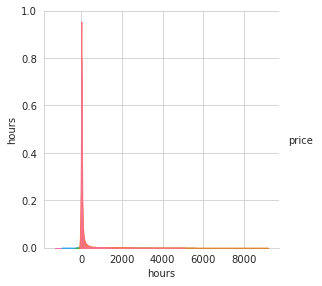

In [255]:
sns.pairplot(dataplot, hue = 'price', diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
             size = 4)
plt.show()

**Games**

In [35]:
data_games = []
for l in parse('data/steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

In [36]:
if True:
    data_games.to_csv('data/data_games.csv', index= False)

In [37]:
data_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


In [39]:
## Tamaño del dataset
data_games.shape

(32135, 16)

El dataset games, tiene 32135 Juegos y 16 Features:

- publisher: editor del juego
- geners: el genero del juego
- app_name: nombre del juego
- title: Titulo del juego
- url: link del juego
- release_date: fecha de lanzamiento
- tags: etiquetas, como genero y si es gratuito o no.
- discount_price: si tiene el descuento y cual es su valor
- revies_url: link de las reviews
- spec: si es sigle, multi, online player, etc.
- price: precio
- early_access: acceso mientras el juegoevoluciona (desarrollo)
- id: identificador numérico del juego
- developer: desarrollador del juego
- sentiment: calificación del juego en general
- metascore: score del juego


In [40]:
# Observamos los nulos
data_games.isna().sum()

publisher          8052
genres             3283
app_name              2
title              2050
url                   0
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29458
dtype: int64

Se observa que el 91% de los datos de metascore son faltantes, el 22% de sentiment y solo el 1% tienen cargados descuentos.

In [ ]:
#vemos los tipos de datos:
data_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32135 entries, 0 to 32134
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publisher       24083 non-null  object 
 1   genres          28852 non-null  object 
 2   app_name        32133 non-null  object 
 3   title           30085 non-null  object 
 4   url             32135 non-null  object 
 5   release_date    30068 non-null  object 
 6   tags            31972 non-null  object 
 7   discount_price  225 non-null    float64
 8   reviews_url     32133 non-null  object 
 9   specs           31465 non-null  object 
 10  price           30758 non-null  object 
 11  early_access    32135 non-null  bool   
 12  id              32133 non-null  object 
 13  developer       28836 non-null  object 
 14  sentiment       24953 non-null  object 
 15  metascore       2677 non-null   object 
dtypes: bool(1), float64(1), object(14)
memory usage: 3.7+ MB


In [42]:
#No dropeamos, solo temamos las líneas en que el id no es NA:
data_games = data_games[data_games['id'].notna()]
data_games['id'] = data_games['id'].astype('int')
data_games.reset_index(inplace=True)

#### Seleccionamos las features relevantes de los dataset para posterior hacer un merge entre ambos y trabajar con uno solo

In [43]:
data_reviews = data_reviews[['product_id','username', 'hours', 'products']]

In [44]:
data_games = data_games[['id','app_name','price','genres','tags','specs']]

In [45]:
data_reviews.head(3)

,product_id,username,hours,products
0,725280,Chaos Syren,0.1,41.0
1,328100,Ariman1,13.2,1386.0
2,725280,freakfantom,0.1,1706.0


In [46]:
data_games.head(3)

,id,app_name,price,genres,tags,specs
0,761140,Lost Summoner Kitty,4.99,"[Action, Casual, Indie, Simulation, Strategy]","[Strategy, Action, Indie, Casual, Simulation]",[Single-player]
1,643980,Ironbound,Free To Play,"[Free to Play, Indie, RPG, Strategy]","[Free to Play, Strategy, Indie, RPG, Card Game...","[Single-player, Multi-player, Online Multi-Pla..."
2,670290,Real Pool 3D - Poolians,Free to Play,"[Casual, Free to Play, Indie, Simulation, Sports]","[Free to Play, Simulation, Sports, Casual, Ind...","[Single-player, Multi-player, Online Multi-Pla..."


#### Realizo merge de los dos dataset

Agregamos al dataset el nombre del Juego, se utiliza la columna en común que identifica a los juegos en ambos dataset, product_id y id

In [47]:
#https://interactivechaos.com/es/manual/tutorial-de-pandas/dataframes-la-funcion-merge
mergeado = pd.merge(data_reviews,data_games, left_on = "product_id", right_on = "id")
mergeado.drop('id', axis=1, inplace=True)
mergeado.head()

,product_id,username,hours,products,app_name,price,genres,tags,specs
0,725280,Chaos Syren,0.1,41.0,Psi Project,2.99,"[Action, Adventure, Indie, Simulation]","[Action, Adventure, Indie, Simulation]","[Single-player, Steam Trading Cards]"
1,725280,freakfantom,0.1,1706.0,Psi Project,2.99,"[Action, Adventure, Indie, Simulation]","[Action, Adventure, Indie, Simulation]","[Single-player, Steam Trading Cards]"
2,328100,Ariman1,13.2,1386.0,Gunspell - Steam Edition,14.99,"[Adventure, Indie, RPG]","[Adventure, RPG, Indie, Puzzle, Match 3]",[Single-player]
3,328100,dll3z,0.4,314.0,Gunspell - Steam Edition,14.99,"[Adventure, Indie, RPG]","[Adventure, RPG, Indie, Puzzle, Match 3]",[Single-player]
4,328100,Nyazicat,2.2,1224.0,Gunspell - Steam Edition,14.99,"[Adventure, Indie, RPG]","[Adventure, RPG, Indie, Puzzle, Match 3]",[Single-player]


In [ ]:
if True:
    mergeado.to_csv('data/mergeado.csv', index= False)

#### Cargamos el Dataset, que ya contiene un merge con las reviews y games. Además cargamos el dataset data_games

Esto lo hacemos para liberar el CPU y cargar ya los dataset filtrados previamente se reinició el Kernel

In [48]:
df = pd.read_csv('data/mergeado.csv')
data_games = pd.read_csv('data/data_games.csv')
#df.head(2)

In [49]:
## Tamaño del dataset
df.shape

(779951, 9)

In [51]:
df1 = df[['product_id','username','app_name','price','hours']]
df1

,product_id,username,app_name,price,hours
0,725280,Chaos Syren,Psi Project,2.99,0.1
1,725280,freakfantom,Psi Project,2.99,0.1
2,328100,Ariman1,Gunspell - Steam Edition,14.99,13.2
3,328100,dll3z,Gunspell - Steam Edition,14.99,0.4
4,328100,Nyazicat,Gunspell - Steam Edition,14.99,2.2
...,...,...,...,...,...
779946,518790,rt974,theHunter: Call of the Wild™,29.99,9.4
779947,518790,Fallenglory,theHunter: Call of the Wild™,29.99,35.8
779948,518790,GooseMan,theHunter: Call of the Wild™,29.99,32.4
779949,518790,lazyboy82,theHunter: Call of the Wild™,29.99,96.9


In [52]:
cnt_de_juegos = df1['product_id'].unique().size
cnt_usuarios = df1['username'].unique().size
print("El dataset tiene {} juegos y {} usuarios".format(cnt_de_juegos,cnt_usuarios))

El dataset tiene 12665 juegos y 540339 usuarios


#### Número total de horas y número de usuarios por juego

Creamos un dataframe con el nombre del juego, el acumulado de horas jugadas por todos los usuarios y la cantidad de usuarios

In [53]:
# Total de número de horas y total de número de usuarios por juego
#user_count = df_data_users.loc[df_data_users[col_play] == 1]. \
#        groupby(col_game)[col_user].agg('count').sort_values(ascending=False)
user_count = df1.groupby('app_name')['username'].agg('count').sort_values(ascending=False) 
# hours_played = df_data_users.loc[df_data_users[col_play] == 1]. \
#        groupby(col_game)[col_hour].agg(np.sum).sort_values(ascending=False)
hours_played = df1.groupby('app_name')['hours'].agg(np.sum).sort_values(ascending=False) 

In [54]:
# Creamos el dataframe con los más jugados con el total de horas y total de usuarios por juego    
nb_games=20
df_top_hours_played = pd.DataFrame({'app_name': hours_played.index,
                                        'hours_played': hours_played.values,
                                        'user_count': user_count.values})[0:nb_games]

In [55]:
df_top_hours_played

,app_name,hours_played,user_count
0,Team Fortress 2,13306145.4,18373
1,Rust,4443474.6,10221
2,Warframe,3406654.9,7321
3,Garry's Mod,2629495.2,7113
4,Arma 3,2573904.2,5976
5,ARK: Survival Evolved,2275927.5,5710
6,Fallout 4,1635305.7,5518
7,Mount & Blade: Warband,1446695.2,5518
8,Counter-Strike: Source,1417299.9,5496
9,DayZ,1348023.4,5301


#### Boxplot para ver la distribución de las horas jugagas por juegos, se elije el top-20 para mostrar

In [56]:
# Get column names from csv.
col_names = df1.columns
col_names

Index(['product_id', 'username', 'app_name', 'price', 'hours'], dtype='object')

In [57]:
# Mask criteria for box plot.
#mask_criteria = df1[col_game].isin(df_top_hours_played['game_name'])
df_box_plot = df1[['hours', 'app_name']]

In [58]:
nb_games=20

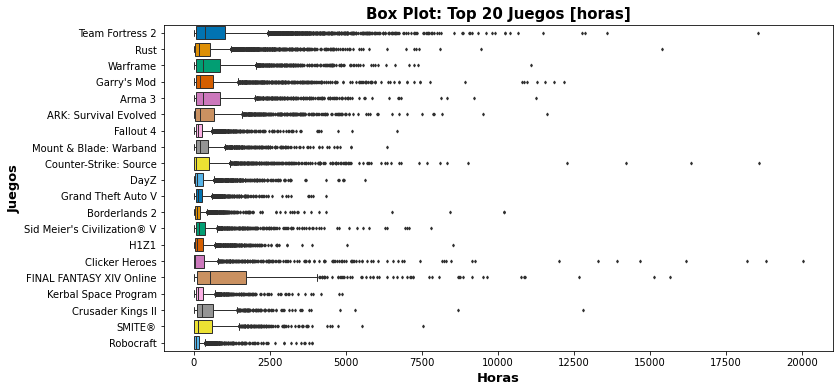

In [59]:
# Creación de box-plot.
fig_h = 1 + 0.25 * max(1, nb_games)
fig, ax = plt.subplots(figsize=(12, fig_h))
sns.set_style("whitegrid")
ax = sns.boxplot(x='hours', y='app_name', data=df_box_plot,
                 order=df_top_hours_played['app_name'].to_list(),
                 palette="colorblind",
                 saturation=1,
                 linewidth=1,
                 fliersize=2)
plt.title('Box Plot: Top {} Juegos [horas]'.format(nb_games),fontsize=15, fontweight='heavy')
plt.xlabel('Horas', fontsize=13, fontweight='demi')
plt.ylabel('Juegos', fontsize=13, fontweight='demi')
plt.show()

In [60]:
df_box_plot.describe()

,hours
count,777314.000000
mean,111.765730
std,389.993556
min,0.000000
25%,4.000000
50%,15.300000
75%,59.500000
max,28164.000000


Para entender mejor la información de los usuarios y sus hábitos de juego, el boxplot anterior muestra el top 20 de los juegos más jugados, basado en el total de horas jugadas.

Se observa, que la distribución de la información de cada juego no es simetrica (no es normal). Mirando más en detalle, los valores fuera de los bígotes, los puntos de cada juego se encuentra en el rango de miles de horas de juego, exponiendo los outliers o valores atípicos. Por ejemplo, Team Fortress 2, un usuario jugó más de  18000 horas, o el Juego Clicker Heroes, hay un usuario jugó más de 20000 horas, que son aproximandamente más de 6 años jugando al mismo juego unas 8 por día.

#### Removemos los Outliers

In [95]:
### Filtrar outliers por juego
## Funcion para obtener filtrar los outliers, pasando el dataframe y la columna
#df_new=[]
#result_total = pd.DataFrame(columns=['A','B','C','D','E','F','G'])
#result_total = pd.DataFrame(columns=[df1.columns])
df_new = pd.DataFrame()

def remove_outlier(df_in, col_name,nombre):
    '''
    Dado un dataframe (df_in) devuelve el mismo pero
    filtrado por los límites superiores e inferiores
    según el críterio de los rangos intercuartilicos * 1.5.
    
    Arguments:
    df_in -- dataframe a filtrar
    col_name -- columna por la cual se va a filtrar los datos, valores discretos
    tipo -- tipo de propiedad para filtrar el dataset
    Returns:
    df_out -- dataframe filtrado por tipo de propiedad y límites usando los rango intercuartilicos
    '''
    df_in_type = df_in[df_in.app_name==nombre] 
    q1 = df_in_type[col_name].quantile(0.25)
    q3 = df_in_type[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    limit_low  = q1-1.5*iqr
    limit_high = q3+1.5*iqr
    df_out = df_in_type.loc[(df_in_type[col_name] > limit_low) & (df_in_type[col_name] < limit_high)]
    #df_sin_outliers = df_new.append(df_out,ignore_index=True)
    #df_sin_outliers.append(df_out)
    return df_out

In [96]:
## cantidad de juegos 12604
nom_juegos = df1['app_name'].unique()
print("Cantidad de Juegos",nom_juegos.shape[0])

Cantidad de Juegos 12658


In [97]:
#cantidad de reviews
df1.shape

(779951, 5)

Creamos una lista con los nombre de los juegos

In [98]:
nom_juegos = df1['app_name'].unique()
#nom_juegos = df1['app_name'].unique()[:3]
#nom_juegos = ['Team Fortress 2','Rust','Warframe']
nom_juegos

array(['Psi Project', 'Gunspell - Steam Edition', 'Somewhere on Zibylon',
       ..., 'Crispy Chicken', 'Mad Dagger',
       'theHunter: Call of the Wild™'], dtype=object)

Dropeamos los nulos

In [100]:
df1 = df1.dropna(subset=['hours','username'], inplace=False)
df1.reset_index(drop=True, inplace=True)

In [101]:
df1.isnull().sum()

product_id       0
username         0
app_name         0
price         6633
hours            0
dtype: int64

#### Corremos función para eliminar los outliers

Como la distribución de cada juegos con respecto a las horas jugadas no es normal, se emplea la regla de 3 Sigmas, se analiza juego por juego, y se deja afuera los valores de los bigótes.

In [102]:
# Filtramos los outliers con  la regla de 3sigmas
df_sin_outliers = []
total_count = 0
df_out = pd.DataFrame()

#current_count=0
print("Cantidad de Juegos {} - lineas {}".format(len(nom_juegos),df1.shape[0]))

for i in tqdm(range(len(nom_juegos))):
    nombre = nom_juegos[i]
    #print(nom_juegos[i])
    total_count = total_count+1
    df_out1 = remove_outlier(df1,'hours',nombre)
    #print("Juego {} - lineas {}".format(nom_juegos[i],df_out1.shape[0]))
    df_out = df_out.append(df_out1)
    #df_out_list = df_out.values.tolist()
    #df_out_list
    #print("Cantidad de lineas {} después de append".format(df_out.shape[0]))

print()
print("Cantidad de Juegos {} - lineas {}".format(len(nom_juegos),df_out.shape[0]))
# comentamos para no pisar el archivo generado por si corremos este campo por error
if True:
    df_out.to_csv('data/df_out_sin_outliers.csv', index= False)

Cantidad de Juegos 12658 - lineas 777296


  0%|          | 0/12658 [00:00<?, ?it/s]


Cantidad de Juegos 12658 - lineas 707305


Guardamos el dataset sin outliers en un csv

In [103]:
df_sin_outliers = pd.read_csv('data/df_out_sin_outliers.csv')

In [104]:
print("Cantidad Reviews dataset original {} - reviews sin outliners {} = {} reviews eliminadas ({:.2f}%)".format(df.shape[0],df_sin_outliers.shape[0],df.shape[0] - df_sin_outliers.shape[0],  float((df.shape[0] - df_sin_outliers.shape[0])/df.shape[0]*100)   ))

Cantidad Reviews dataset original 759125 - reviews sin outliners 707305 = 51820 reviews eliminadas (6.83%)


#### Graficamos luego de quitar los outliers

In [105]:
# Mask criteria for box plot.
#mask_criteria = df1[col_game].isin(df_top_hours_played['game_name'])
df_box_plot = df_sin_outliers[['hours', 'app_name']]

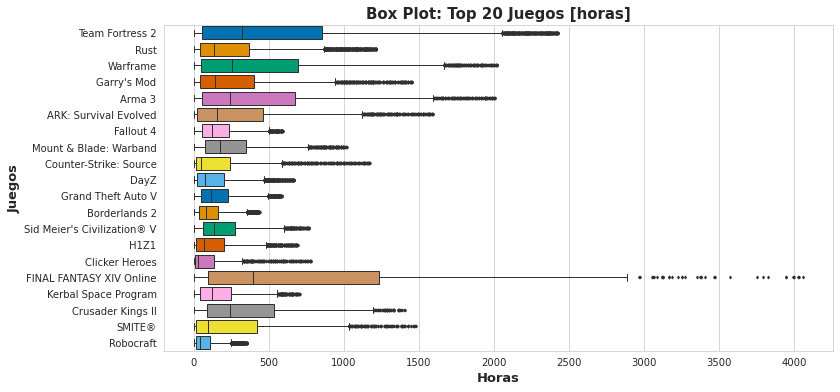

In [106]:
# Creación de box-plot.
nb_games = 20
fig_h = 1 + 0.25 * max(1, nb_games)
fig, ax = plt.subplots(figsize=(12, fig_h))
sns.set_style("whitegrid")
ax = sns.boxplot(x='hours', y='app_name', data=df_box_plot,
                 order=df_top_hours_played['app_name'].to_list(),
                 palette="colorblind",
                 saturation=1,
                 linewidth=1,
                 fliersize=2)
plt.title('Box Plot: Top {} Juegos [horas]'.format(nb_games),fontsize=15, fontweight='heavy')
plt.xlabel('Horas', fontsize=13, fontweight='demi')
plt.ylabel('Juegos', fontsize=13, fontweight='demi')
plt.show()

El segmento que divide la caja en dos partes es la mediana, de allí se observa que la distribución presenta una asimetría positiva o segada a la derecha, la parte más larga de la caja es la parte superior a la mediana. Los datos se concentran en la parte inferior de la distribución. La media suele ser mayor que la mediana.  Esto no quiere decir que ese lado contenga más datos. Indica un rango más amplio, por lo que los datos estarán mas dispersos. Un rango menos amplio, indica que los datos están más próximos.

#### Videos Juegos Vs Precios

In [107]:
data = df_sin_outliers

In [108]:
data2 = df_sin_outliers.groupby(['product_id'], as_index=False)['price'].count().sort_values(['price'], ascending=False)

In [109]:
data2

,product_id,price
19,440,17317
2035,252490,9244
860,49520,6760
5364,377160,6554
2492,271590,5545
...,...,...
2215,260410,0
4528,349580,0
5818,394740,0
2236,261570,0


#### Graficamos la cantidad de usuarios agrupados en bins según en precio

In [110]:
intervalos = range(min(data2.price.values), max(data2.price.values) + 2) #calculamos los extremos de los intervalos
intervalos

range(0, 17319)

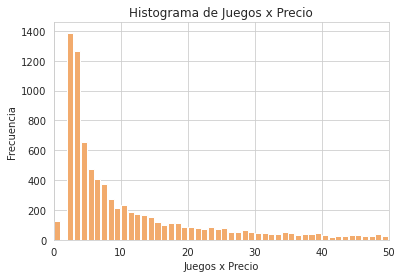

In [111]:
# Graficamos la cantidad de usuarios agrupados en bins según en precio
plt.hist(x=data2.price.values, bins=intervalos, color='#F2AB6D', rwidth=0.90)
plt.title('Histograma de Juegos x Precio')
plt.xlim([0, 50])
plt.xlabel('Juegos x Precio')
plt.ylabel('Frecuencia')
#plot.xticks(intervalos)
#for rect in axes[0].patches:
#    axes[0].text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)
plt.show()

In [112]:
#df = mergeado.dropna(subset=['price'], inplace=False)
#df['price'].value_counts()

In [113]:
#df.shape

In [72]:
#df['price'] = df['price'].astype('int')
##data_games['id'] = data_games['id'].astype('int')
#df['price'] 
data[data["price"] == "0"].price.count()

0

In [114]:
# Obtenemos los valores que toma la variable price
data['price'].unique()

array(['14.99', '9.99', '19.99', '4.99', nan, '5.99', '11.99', '3.99',
       'Free to Play', '29.99', '2.99', '1.99', '0.99', '18.99', '39.99',
       '7.99', '13.99', '6.99', 'Free To Play', 'Free', '20.0', '59.99',
       '12.99', '15.99', '24.99', 'Play for Free!', '1.87', '16.99',
       '8.99', '17.99', '44.99', '5.65', '49.99', '34.99', '0.5', '0.89',
       '119.99', '0.49', '10.99', '10.96', '79.99', '189.96', '74.99',
       '15.0', '2.97', '4.0', '11.15', 'Play WARMACHINE: Tactics Demo',
       '4.68', '12.89', 'Play the Demo', '54.99', '31.99', '49.0',
       '13.98', '44.98', '74.76', '32.99', '4.49', '189.0', '0.98',
       '202.76', '61.99', '13.37', '3.0', '69.99', 'Free to Use', '87.94',
       '99.99', 'Install Now', '7.49', '16.06', '3.49', '19.98', '3.33',
       '23.96', 'Free Mod', '21.99', '6.66', '64.99', '19.95', '2.49',
       '139.92', '199.0', '23.99', '12.0', '1.0', '9.95', 'Third-party',
       '2.0', '160.91', '20.99', '10.0', '299.99', '26.99', 'Free Mov

In [115]:
#Creamos listas para Imputar los valoeres categoricos por numericos
lista_free = ['Free to Play','Free To Play', 'Free','Play for Free!','Play WARMACHINE: Tactics Demo','Play the Demo','Free Mod','Free to Use','Install Now','Free to Try','Third-party','Free Movie', 'Free HITMAN™ Holiday Pack']
lista_cost = ['Starting at $449.00']

In [116]:
##df.reset_index(inplace=True)
#df2 = df.loc[df['price'].isin(lista_free)]
#df2.shape
##df['price'] = df.loc[df['price'].isin(lista_free)]

Convertimos los valores que machean en la lista lista_free en 0

In [117]:
#df.loc[df['price'] == lista_free, 'price'] = '0'
#df.reset_index(inplace=True)
data.loc[data["price"].isin(lista_free), "price"] = "0"
data[data["price"] == "0"].price.count()

131689

Seteamos el valor de price en el valor míninmo 449 del precio de jueo para los que están en la lista_cost

In [118]:
#df.loc[df['price'] == lista_cost, 'price'] = '449'
data.loc[data["price"].isin(lista_cost), "price"] = "449"

In [119]:
#data[data.price.isnull()].value_counts()
data.app_name[data.price.isnull()].value_counts()

Ori and the Blind Forest           1021
Tactical Intervention               561
America's Army: Proving Grounds     394
Serena                              386
Romero's Aftermath                  364
                                   ... 
Monuments of Mars                     2
Basketball Pro Management 2014        2
Pilot Crusader                        2
Zen Fish SIM                          2
Heroes of Arca                        2
Name: app_name, Length: 124, dtype: int64

In [120]:
## Hay 6047 revies con precio NaN, hacemos un fillna y rellenamos con precio 0
#data.price.fillna(0, inplace=True)
data.dropna(subset=['price'], inplace=True)

In [121]:
data.price.isnull().sum()

0

Convierto price de object to int

In [122]:
#df.reset_index(drop=True,inplace=True)
data = data.copy()
data['price'] = data['price'].astype('float').astype('int')

In [123]:
data['price'].unique()

array([ 14,   9,  19,   4,   5,  11,   3,   0,  29,   2,   1,  18,  39,
         7,  13,   6,  20,  59,  12,  15,  24,  16,   8,  17,  44,  49,
        34, 119,  10,  79, 189,  74,  54,  31,  32, 202,  61,  69,  87,
        99,  23,  21,  64, 139, 199, 160, 299,  26, 771])

#### Distribucion de los precios de los juegos

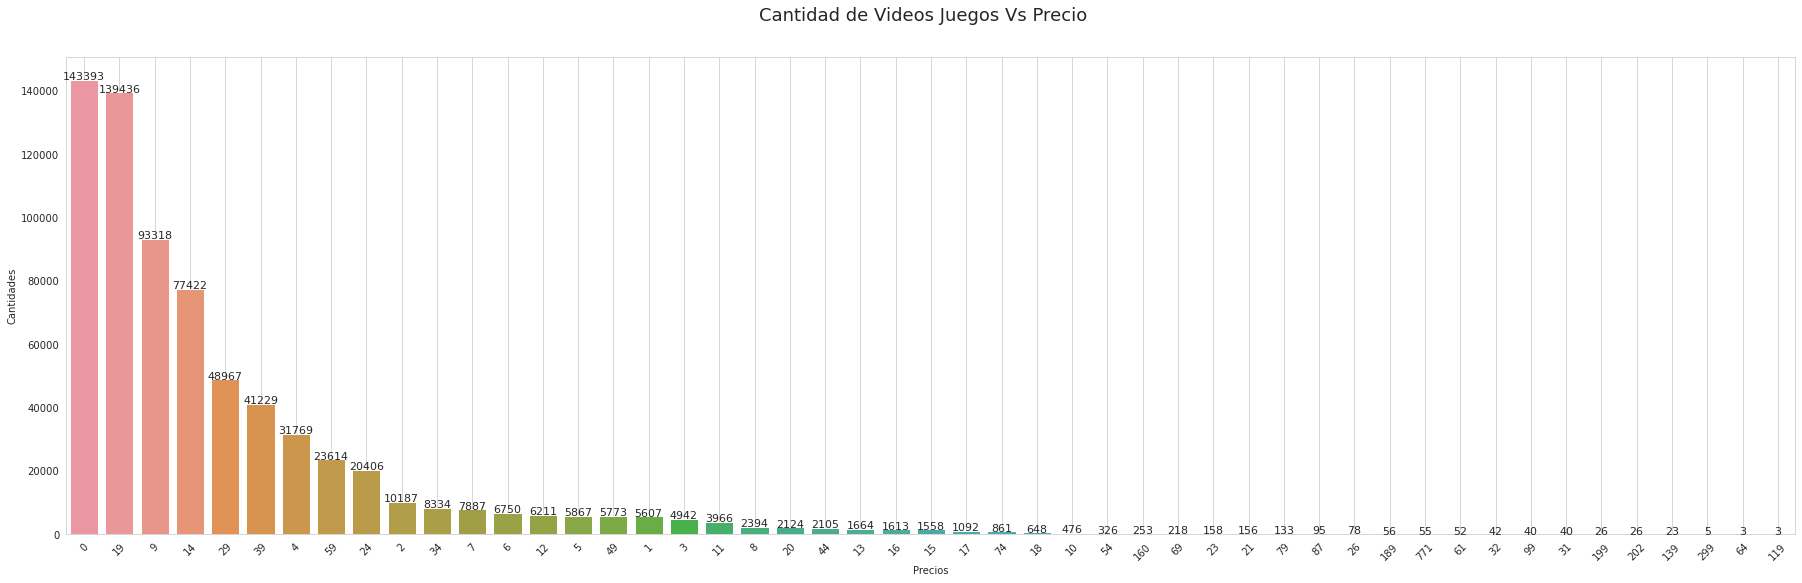

In [124]:
## creamos la figura con subplots de 1 linea 2 columnas
fig, axes = plt.subplots(1,1, figsize=(25, 8))
fig.suptitle('Cantidad de Videos Juegos Vs Precio', fontsize=18)
#padding between subplots. Pass a float parameter to specify the amount of padding between subplots.
fig.tight_layout(pad=2.0)

# GRacount 0
sns.countplot(data = data, x = "price", orient='v', order = data['price'].value_counts().index)
#axes.set_title("Todas los tipos: ",fontsize = 10, color = "w", fontstretch=0, backgroundcolor="SteelBlue")
#plt.sca(axes[0, 1])
#plt.sca(axes[0])
plt.xticks(rotation=45)
axes.set_xlabel("Precios")
axes.set_ylabel("Cantidades")
plt.grid()

for rect in axes.patches:
    axes.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)

#Grafico 1
#sns.countplot(data = df, x = "pr", orient='v', ax=axes[1], order = df['property_type_2'].value_counts().index)
#axes[1].set_title("Agrupados: ",fontsize = 10, color = "w", fontstretch=0, backgroundcolor="SteelBlue")
#plt.sca(axes[1])
#plt.xticks(rotation=45)
#plt.grid()

#for rect in axes[1].patches:
#    axes[1].text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)

Se observa que el 78% de los juegos comprados tienen un valor menor a 19 dolares y un 23% de los juegos adquiridos son gratuitos.

#### Cantidad de videos Juegos por usuarios

In [125]:
# Cargamos el Dataset
df = pd.read_csv('data/df_out_sin_outliers.csv')

In [126]:
#Seleccionamos las features con tentativa de uso
df1 = df[['product_id','username','app_name','price','hours']]

In [129]:
# Obtenemos por usuarios la cantidad de productos adquiridos
Pop_rec = df1.groupby(['username'], as_index=False)['product_id'].count()

In [130]:
#Renombramos los nombres de las columnas
Pop_rec.rename(columns={'product_id': 'cnt_juegosxusuarios'}, inplace=True)
#data2.head(20).sort_values(['cnt_juegosxusuarios'], ascending=False).head(10)
Pop_rec.head(10)

,username,cnt_juegosxusuarios
0,!,1
1,! ZerZ,2
2,! ! ŦŕĩŽǿЯëќ™ ! !,1
3,! Alga,2
4,! DeadlyDeal !,1
5,! Dr Feelgood,1
6,! EREN,1
7,! Monika !,2
8,! Taz the Husky,4
9,! ToxicWizzard,1


In [131]:
Pop_rec.sort_values(['cnt_juegosxusuarios'], ascending=False).describe()

,cnt_juegosxusuarios
count,494795.000000
mean,1.429491
std,1.832017
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,162.000000


Vemos la distribución de la cantidad de usuarios por juego, teniendo una media de 1.44, un mínimo de 1 juego y un máximo de 213. Tambíen se observa que el 75% de los usuarios tiene 1 juego.

In [135]:
Pop_rec_sort = Pop_rec.sort_values(['cnt_juegosxusuarios'], ascending=False)
Pop_rec_sort.describe()

,cnt_juegosxusuarios
count,494795.000000
mean,1.429491
std,1.832017
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,162.000000


Ahora analizamos la características estadísticas de los top 100:

In [136]:
data_top = Pop_rec.sort_values(['cnt_juegosxusuarios'], ascending=False).head(100)

In [137]:
data_top.describe()

,cnt_juegosxusuarios
count,100.000000
mean,70.370000
std,24.457613
min,47.000000
25%,52.750000
50%,64.000000
75%,81.250000
max,162.000000


#### A continuación analizamos los 10000 usuarios que más juegos tienen y la cantidad de juegos por usurios sobre todo el conjunto de datos

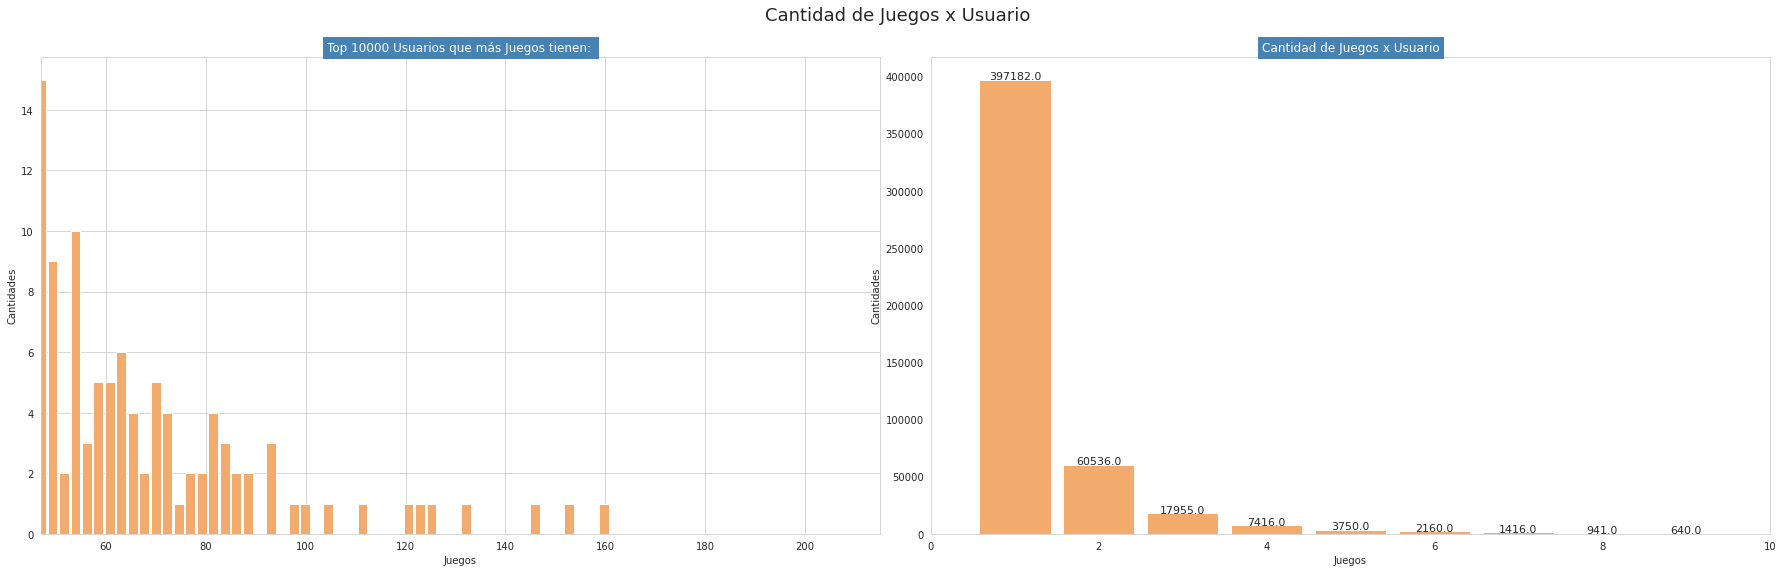

In [138]:
intervalos = range(min(Pop_rec_sort.cnt_juegosxusuarios), max(Pop_rec_sort.cnt_juegosxusuarios) + 2) #calculamos los extremos de los intervalos

## creamos la figura con subplots de 1 linea 2 columnas
fig, axes = plt.subplots(1,2, figsize=(25, 8))
fig.suptitle('Cantidad de Juegos x Usuario', fontsize=18)
#padding between subplots. Pass a float parameter to specify the amount of padding between subplots.
fig.tight_layout(pad=2.0)
plt.grid()

# Grafico 0
#sns.countplot(data = df, x = "price", orient='v', order = df['price'].value_counts().index)
axes[0].set_title("Top 10000 Usuarios que más Juegos tienen: ",fontsize = 12, color = "w", fontstretch=0, backgroundcolor="SteelBlue")
axes[0].hist(x=data_top.cnt_juegosxusuarios, bins=50, color='#F2AB6D', rwidth=0.85, align='left')
#axes.set_title("Todas los tipos: ",fontsize = 10, color = "w", fontstretch=0, backgroundcolor="SteelBlue")
#plt.sca(axes[0, 1])
#plt.sca(axes[0])
plt.xticks(rotation=45)
axes[0].set_xlabel("Juegos")
axes[0].set_ylabel("Cantidades")
axes[0].set_xlim([47,215]) ## limite en x, para acotar y quitar los outliers

#count=0
#for rect in axes[0].patches:
#    count +=1
#    if count < 12:  
#        # prints the quit message
#        #print(quit)
#        axes[0].text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)


#Grafico 1

axes[1].set_title("Cantidad de Juegos x Usuario",fontsize = 12, color = "w", fontstretch=0, backgroundcolor="SteelBlue")
axes[1].hist(x=Pop_rec_sort.cnt_juegosxusuarios, bins=intervalos, color='#F2AB6D', rwidth=0.85, align='left')
#plt.sca(axes[0, 1])
#plt.sca(axes[0])
plt.xticks(rotation=0)
axes[1].set_xlabel("Juegos")
axes[1].set_ylabel("Cantidades")
axes[1].set_xlim([0,10]) ## limite en x, para acotar y quitar los outliers

count=0
for rect in axes[1].patches:
    count +=1
    if count < 10:  
        axes[1].text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)

plt.show()

En el gráfico de la izaquieda observamos el top 10000 de los usuarios que han comprado más juego y su distribución. Se observa que el 67.8% ha comprado 5 juegos, y 1.5% ha comprada 10 juegos. El gráfico de la derecha se grafica todos los datos, el 55% de los usuarios ha comprado 1 Juego, el 8.5% 2 Juegos y el 1% 3 Juegos.

#### El Juego más comprado es el más Jugado?

Vamos a determisnar si el juego más comprado se corresponde con el más jugado. Por cada juego, vamos a computar el total de usuarios y el total de tiempo por juego por todos los usuarios. El resultado lo mostraremos a continuacion, solo mostraremos el top 20 de los juegos con más horas/usuarios.

Usamos un Histograma para visualizar el resultado de la tabla de abajo. Los Juegos están ordenados de forma decreciente basado en el número de usuarios. El color del gradiente representa el total de horas jugadas.

Podemos usar la tabla de abajo para comparar con el Histograma si se mantiene el order y la lógica, juego más jugado es el que tiene más usuarios. Para verlo más claro y en un mismo gráfico se hace el histograma que contempla las dos variables, eje x la cantidad de usuarios y el color del gradiente es según la cantidad de horas jugadas.

In [139]:
# Top de juegos más jugados según el número de horas
top = 20
game_total_hrs = df1.groupby(by='app_name')['hours'].sum()
most_played_games = game_total_hrs.sort_values(ascending=False)[:top]
most_played_games.head(20)

app_name
Team Fortress 2                     9384320.8
Rust                                2354540.7
Warframe                            2290502.1
Arma 3                              1635550.7
Garry's Mod                         1214971.9
ARK: Survival Evolved               1185788.6
Fallout 4                           1027882.9
Grand Theft Auto V                   855617.3
Mount & Blade: Warband               827120.3
Borderlands 2                        756150.4
DayZ                                 680989.3
Sid Meier's Civilization® V          662635.2
Crusader Kings II                    584648.2
Kerbal Space Program                 530220.6
H1Z1                                 530210.3
FINAL FANTASY XIV Online             517805.3
SMITE®                               481046.8
Tom Clancy's Rainbow Six® Siege      457344.0
Counter-Strike: Source               449981.0
Counter-Strike: Global Offensive     447260.1
Name: hours, dtype: float64

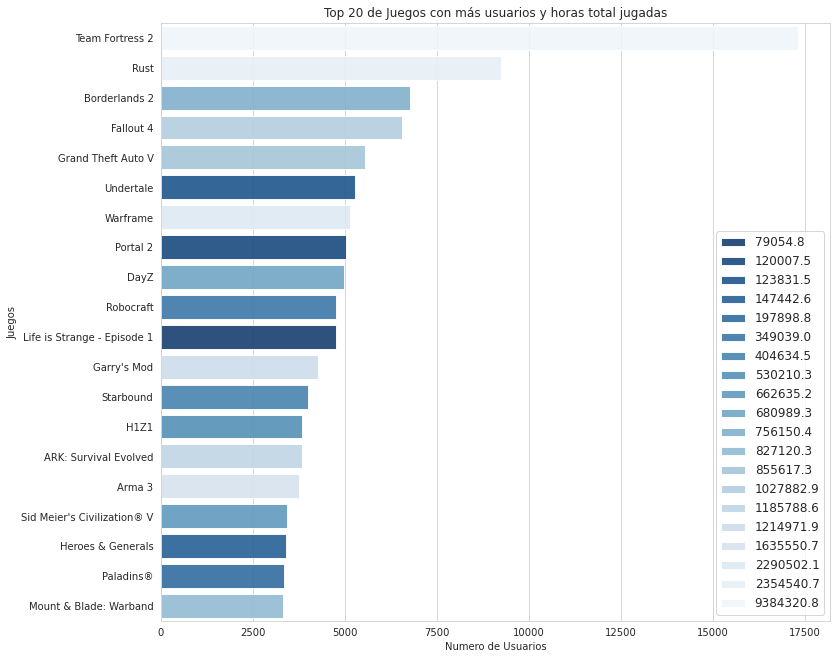

In [140]:
# Juegos con mayor número de usuarios vs horas jugadas
game_freq = df1.groupby(by='app_name').agg({'username': 'count', 'hours': 'sum'}).reset_index()
top20 = game_freq.sort_values(by='username',ascending=False)[:20].reset_index()
#print(top20)
top20['hours']=top20['hours'].round(1)
# histogram
fig_h = 1 + 0.25 * max(1, 2*top)
fig, ax = plt.subplots(figsize=(12, fig_h))

#fig, ax = plt.figure(figsize=(20, 10))
#sns.set(font_scale = 2)
ax = sns.barplot(x='username', y='app_name', hue='hours',alpha=0.9,data=top20, palette='Blues_r',dodge=False)
ax.set(xlabel='Numero de Usuarios', ylabel='Juegos', title="Top {} de Juegos con más usuarios y horas total jugadas".format(top))
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.legend(fontsize=12)
plt.show()

Se observa que no se guarda la relación supuesta, el color del gradiente  no es un degradé continua según el orden de los juegos por usuarios. Por ejemplo,  el "bordelands 2" está en el top3 según el número de usuarios, pero está en el puesto número 12 según la cantidad de horas jugadas total. A continuación vamos analizar solamente los que fueron jugados, suponemos que los que tienen una duración mayor de 1 hora fueron jugados y los que no, solamente comprados.

In [141]:
# Los comprados que consideramos que no se han jugado, tiempo menor o = a 1 hora
print("Cantidad de juegos comprados {} - Los comprados que consideramos que no se han jugado, tiempo menor o = a 1 hora: {} ({:.2f}%)".format(df1.shape[0], df1[df1['hours']<=1].shape[0], float((df1[df1['hours']<=1].shape[0])/df1.shape[0]*100)   ))

Cantidad de juegos comprados 707305 - Los comprados que consideramos que no se han jugado, tiempo menor o = a 1 hora: 78411 (11.09%)


In [142]:
# Los comprados y jugados, cuyo tiempo es mayor a una hora.
print("Cantidad de juegos comprados {} - Los comprados que consideramos que se han jugado, tiempo menor o = a 1 hora: {} ({:.2f}%)".format(df1.shape[0], df1[df1['hours']<=1].shape[0], float((df1[df1['hours']>=1].shape[0])/df1.shape[0]*100)   ))

Cantidad de juegos comprados 707305 - Los comprados que consideramos que se han jugado, tiempo menor o = a 1 hora: 78411 (89.72%)


Se observa que el 10,63% de los juegos solamente fueron adquiridos y no jugados tomando como criterio si las horas de juego es menor a 1.

Text(0, 0.5, 'Usuarios')

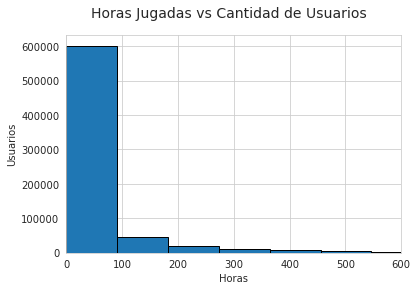

In [153]:
##Distribucion
plt.suptitle('Horas Jugadas vs Cantidad de Usuarios', size = 14);
plt.hist(df1['hours'], bins=100, alpha=1, edgecolor = 'black',  linewidth=1)
plt.xlim([0,600]) ## limite en x, para acotar y quitar los outliers
plt.xlabel("Horas")
plt.ylabel("Usuarios")

En el histograma anterior se observa la distribucion de las horas jugadas de todos los juegos y usuarios, observando una concentración de horas menor a 250.

#### Graficamos solamente a los que fueron jugados
quitamos los que suponemos que no fueron jugados para ver si cambia la relación

In [154]:
#df1 = df1.copy()
#index=df1[df1['hours']==0].index
#df1.drop(index,inplace=True)
#game_total_hrs = df1.groupby(by='app_name')['hours'].sum()
#most_played_games = game_total_hrs.sort_values(ascending=False)[:20]

<ipython-input-155-edf004e13da9>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(axes.get_xticklabels(), rotation=0, fontsize=10)


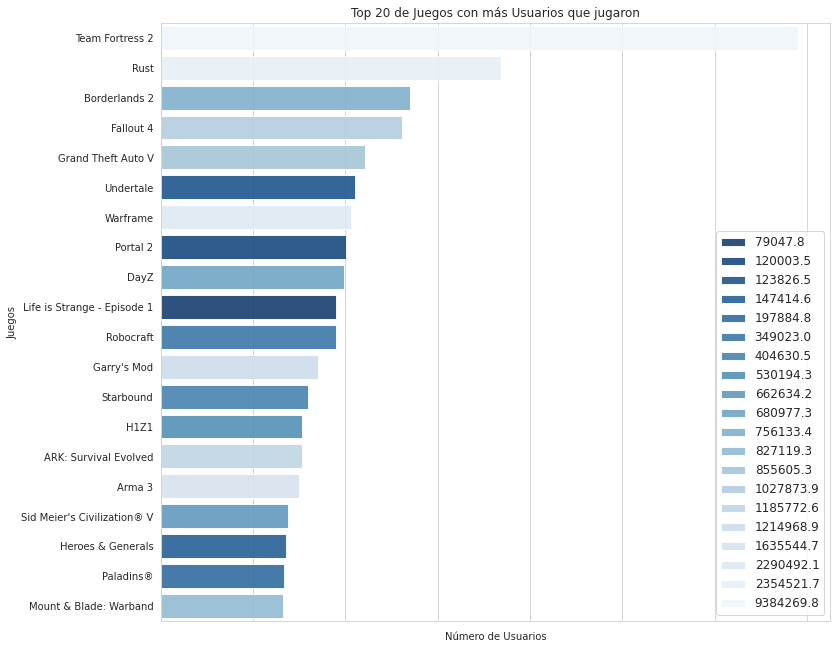

In [155]:
#Consideramos solo a los que han jugado por lo menos 1 hora
df1=df1.copy()
index=df1[df1['hours']==1].index
df1.drop(index,inplace=True)
game_total_hrs = df1.groupby(by='app_name')['hours'].sum()
most_played_games = game_total_hrs.sort_values(ascending=False)[:20]
# Juegos con el mayor número de usuarios
game_freq = df1.groupby(by='app_name').agg({'username': 'count', 'hours': 'sum'}).reset_index()
top20 = game_freq.sort_values(by='username',ascending=False)[:20].reset_index()
top20['hours']=top20['hours'].round(1)

fig_h = 1 + 0.25 * max(1, 2*top)
fig, axes = plt.subplots(figsize=(12, fig_h))

#plt.figure(figsize=(20, 8))
#axes = sns.set(font_scale = 2)
axes = sns.barplot(x='username', y='app_name', hue='hours',alpha=0.9,data=top20, palette='Blues_r',dodge=False)
axes.set(xlabel='Número de Usuarios', ylabel='Juegos', title='Top {} de Juegos con más Usuarios que jugaron'.format(top))
#axes.set_xticklabels(ax.get_xticklabels(), rotation=90)
axes.set_xticklabels(axes.get_xticklabels(), rotation=0, fontsize=10)
axes.set_yticklabels(axes.get_yticklabels(), rotation=0, fontsize=10)
axes.xaxis.set_tick_params(labelsize=14)
axes.legend(fontsize=12)
plt.show()

No se observan cambios en el top 5 con respecto a la gráfica anterior

In [156]:
print("Cantidad de Juegos {} y Cantidad de Usuarios {}".format(df1.app_name.nunique(),df1.username.nunique()))

Cantidad de Juegos 9887 y Cantidad de Usuarios 491789


### Ingenieria de Features
El dataset de las reviews no contiene una feature con la calificación de los juegos por usuarios explicitamente, por ellos se decidió crear del rating a partir de las horas Jugadas, crearemos un rating binario, `0` si la calificación es negativa y `1` si es positiva.  Si las horas jugadas por un usuario X de un juego Y es superior a la mediana del total de horas jugadas del juego Y, se lo califica como positivo, si es menor como negativo.

In [158]:
#df = pd.read_csv('data/mergeado.csv')
## Cargamos el dataset sin los outliers
df = pd.read_csv('data/df_out_sin_outliers.csv')
data_games = pd.read_csv('data/data_games.csv')
#df.head(2)

In [160]:
## Tamaño del dataset
df.shape

(707305, 5)

In [161]:
df1 = df[['product_id','username','app_name','price','hours']]
df1

,product_id,username,app_name,price,hours
0,328100,dll3z,Gunspell - Steam Edition,14.99,0.4
1,328100,Nyazicat,Gunspell - Steam Edition,14.99,2.2
2,328100,novocain,Gunspell - Steam Edition,14.99,3.8
3,328100,raixel,Gunspell - Steam Edition,14.99,3.2
4,328100,Shwgar,Gunspell - Steam Edition,14.99,1.4
...,...,...,...,...,...
707300,518790,rt974,theHunter: Call of the Wild™,29.99,9.4
707301,518790,Fallenglory,theHunter: Call of the Wild™,29.99,35.8
707302,518790,GooseMan,theHunter: Call of the Wild™,29.99,32.4
707303,518790,lazyboy82,theHunter: Call of the Wild™,29.99,96.9


In [162]:
#df1 = df.copy()

In [166]:
#Asumimos score inicial 0 para luego reemplazarlo por el valor que corresponda según las horas jugadas
df1.reset_index(inplace=True,drop=True)
df1['score'] = 0

In [167]:
df1

,product_id,username,app_name,price,hours,score
0,328100,dll3z,Gunspell - Steam Edition,14.99,0.4,0
1,328100,Nyazicat,Gunspell - Steam Edition,14.99,2.2,0
2,328100,novocain,Gunspell - Steam Edition,14.99,3.8,0
3,328100,raixel,Gunspell - Steam Edition,14.99,3.2,0
4,328100,Shwgar,Gunspell - Steam Edition,14.99,1.4,0
...,...,...,...,...,...,...
707300,518790,rt974,theHunter: Call of the Wild™,29.99,9.4,0
707301,518790,Fallenglory,theHunter: Call of the Wild™,29.99,35.8,0
707302,518790,GooseMan,theHunter: Call of the Wild™,29.99,32.4,0
707303,518790,lazyboy82,theHunter: Call of the Wild™,29.99,96.9,0


In [168]:
# convertimos en flotante los valores
df1.product_id.astype(float)

0         328100.0
1         328100.0
2         328100.0
3         328100.0
4         328100.0
            ...   
707300    518790.0
707301    518790.0
707302    518790.0
707303    518790.0
707304    518790.0
Name: product_id, Length: 707305, dtype: float64

In [169]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707305 entries, 0 to 707304
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   product_id  707305 non-null  int64  
 1   username    707305 non-null  object 
 2   app_name    707305 non-null  object 
 3   price       701401 non-null  object 
 4   hours       707305 non-null  float64
 5   score       707305 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 32.4+ MB


In [170]:
# convertimos en flotante los valores
df1.hours = df1.hours.astype(float)

In [171]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707305 entries, 0 to 707304
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   product_id  707305 non-null  int64  
 1   username    707305 non-null  object 
 2   app_name    707305 non-null  object 
 3   price       701401 non-null  object 
 4   hours       707305 non-null  float64
 5   score       707305 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 32.4+ MB


In [172]:
print("Cantidad de Juegos {} y Cantidad de Usuarios {}".format(df1.app_name.nunique(),df1.username.nunique()))

Cantidad de Juegos 9887 y Cantidad de Usuarios 494795


In [173]:
# las medianas de cada juegos de horas jugadas
games_median = df1.groupby('app_name')['hours'].agg('median').sort_values(ascending=False)

In [176]:
# Mostramos el nombre del juego, la cantidad de usuarios, y la mediana de las horas jugadas
df1.groupby(by='app_name').agg({'username': 'count' ,'hours': 'median'}).reset_index()

,app_name,username,hours
0,! That Bastard Is Trying To Steal Our Gold !,6,4.65
1,"""Glow Ball"" - The billiard puzzle game",4,2.50
2,#monstercakes,12,15.95
3,$1 Ride,18,1.40
4,- Arcane RERaise -,3,3.10
...,...,...,...
9882,神明的一天世界(God's One Day World),3,2.20
9883,红石遗迹 - Red Obsidian Remnant,2,0.50
9884,軒轅劍外傳穹之扉(The Gate of Firmament),12,11.55
9885,龙魂时刻,7,0.40


In [177]:
## Juegos que no tienen horas jugadas
games_median.isnull().sum()

0

In [178]:
games_median.fillna(0, inplace=True)

Creamos el dataframe con los más jugados con el total de horas y total de usuarios por juego    

In [179]:
# Creamos el dataframe con los más jugados con el total de horas y total de usuarios por juego    
#nb_games=20
#df_games_median = pd.DataFrame({'app_name': games_median.index,
#                                        'median_hours_played': games_median.values})[0:nb_games]
df_games_median = pd.DataFrame({'app_name': games_median.index,
                                        'median_hours_played': games_median.values})
df_games_median

,app_name,median_hours_played
0,Stream Avatars,706.45
1,Transport Defender,676.05
2,Race Track Builder,674.15
3,Tapocalypse,601.25
4,MODO indie,514.85
...,...,...
9882,Jacob,0.10
9883,Mortal Kombat: Legacy II,0.10
9884,Capsule Force,0.10
9885,GTR Evolution Expansion Pack for RACE 07,0.00


In [180]:
# Agregamos el nombre del juego haciendo un marge y tomando el nombre del juedo del dataset data_games
df_games_median = pd.merge(df_games_median,data_games, left_on = "app_name", right_on = "app_name")
df_games_median.drop(['genres','publisher','title','url','release_date','tags','discount_price','reviews_url','specs','price','early_access','developer','sentiment','metascore'], axis=1, inplace=True)
#df_games_median.head()

In [181]:
# Eliminamos los nulos y reseteamos el indice
df_games_median.dropna(inplace=True)
df_games_median.id.isnull().sum()
df_games_median.id = df_games_median.id.astype(int)
df_games_median.reset_index(drop=True,inplace=True)  #reseteamos el indice y quitamos la columna index

In [182]:
#df_games_median[df_games_median['app_name'] == 'Rust']

In [183]:
df_games_median.shape

(9904, 3)

In [184]:
df_games_median.head()

,app_name,median_hours_played,id
0,Stream Avatars,706.45,665300
1,Transport Defender,676.05,685310
2,Race Track Builder,674.15,388980
3,Tapocalypse,601.25,567000
4,MODO indie,514.85,321540


In [185]:
#df_games_median[df_games_median.id == 238750 ]

In [186]:
#nombres de juegos y su cantidad
nom_juegos = df1['app_name'].unique()
nom_juegos.shape

(9887,)

In [188]:
#(df_games_median.loc[df_games_median.app_name == 'Stream Avatars' ].median_hours_played).astype(float)

In [189]:
#df_games_median[df_games_median.app_name == 'Grand Theft Auto V' ]

In [191]:
#median_hours_x = df_games_median.loc[df_games_median.app_name == 'Grand Theft Auto V' ].median_hours_played
#median_hours_x

In [192]:
#median_hours_x == 110.0

#### Creación del rating
Se crea un score, donde si el tiempo jugado por un usuario de un juego X supera el tiempo de la mediana de ese juego se lo califica como positivo, es decir con el valor 1, en caso contrario el score será de "0"

In [ ]:
numero = 0
##conda install tqdm
#from tqdm import tqdm
from tqdm.notebook import tqdm

#for i in tqdm(range(df1.shape[0])):
#for i in tqdm(range(0,df1.shape[0]-1)):
for i in tqdm(range(0,df1.shape[0])):
#for i in tqdm(range(1,df1.shape[0]-1)):

    #i+= 1
#    singleCount=i
#    currentCount=i
#   print("XXXXXXXXXXXXXXXXXXXX")
#    print("i",i)

    #product_id = df1.product_id[i]
    app_name_i = df1.app_name[i]

    #print("product_id: ",product_id)
    #print("hours en df1: ", df1.hours[i])
    
    #print("index {} - productID {} - hours {}- median_hours_played: {}".format(i, product_id, df1.hours[i] , (df_games_median.loc[df_games_median.id == product_id ].median_hours_played).astype(float) ))
    #print("index {} - app_name {} - hours {}- median_hours_played: {}".format(i, app_name_i, df1.hours[i] , (df_games_median.loc[df_games_median.app_name == app_name_i ].median_hours_played).astype(float) ))

    #print("productID {} - median_hours_played: {}".format(df1.product_id[i], df1.hours[i]))
    
#   print("hours >= median", float(df1.hours[i]) >= float(df_games_median.loc[df_games_median.id == product_id ].median_hours_played.values) )
#   print("hours < median", float(df1.hours[i]) < float(df_games_median.loc[df_games_median.id == product_id ].median_hours_played.values))
    
    #x = float(df1.hours[i]) >= int(df_games_median.loc[df_games_median.id == product_id ].median_hours_played.values)
    
    
    #x = float(df1.hours[i]) >= (df_games_median.loc[df_games_median.id == product_id ].median_hours_played.values).astype(float)
    x = float(df1.hours[i]) >= (df_games_median.loc[df_games_median.app_name == app_name_i ].median_hours_played.values).astype(float)

    #print("salida de x:",np.any(x, axis=0))

    x = np.any(x, axis=0)
    
    if x == True:
        #print("x is True")
        #print("TRUE - index {} - app_name {} - hours {}- median_hours_played: {}".format(i, app_name_i, df1.hours[i] , (df_games_median.loc[df_games_median.app_name == app_name_i ].median_hours_played).astype(float) ))

        #df1.loc[float(df1.hours[i]) >= float(df_games_median.loc[df_games_median.id == product_id ].median_hours_played.values), 'score']  = 1
        df1.loc[i,'score']  = 1
        #print("ratting", df1.ratting.loc[i])
    elif x == False:
        #print("x is False")
        #print("FALSE - index {} - app_name {} - hours {}- median_hours_played: {}".format(i, app_name_i, df1.hours[i] , (df_games_median.loc[df_games_median.app_name == app_name_i ].median_hours_played).astype(float) ))

        #df1.loc[float(df1.hours[i]) < float(df_games_median.loc[df_games_median.id == product_id ].median_hours_played.values), 'score']  = 0
        df1.loc[i, 'score']  = 0
        #print("ratting", df1.ratting.loc[i])
#

#### Limitador para probar y cortar antes
#    numero += 1
#    #print("numero",numero)
#    if numero > 5:
#        #print(i)
#        df1.head()
#        break

#df1

## Guardamos el dataset con los scores
if True:
    df1.to_csv('data/df_ratings.csv', index= False)


  0%|          | 0/707312 [00:00<?, ?it/s]

Se truncaron las últimas líneas 5000 del resultado de transmisión.
TRUE - index 704812 - app_name DayZ - hours 184.1- median_hours_played: 151    70.25
Name: median_hours_played, dtype: float64
TRUE - index 704813 - app_name DayZ - hours 170.6- median_hours_played: 151    70.25
Name: median_hours_played, dtype: float64
TRUE - index 704814 - app_name DayZ - hours 99.2- median_hours_played: 151    70.25
Name: median_hours_played, dtype: float64
TRUE - index 704815 - app_name DayZ - hours 462.6- median_hours_played: 151    70.25
Name: median_hours_played, dtype: float64
TRUE - index 704816 - app_name DayZ - hours 108.8- median_hours_played: 151    70.25
Name: median_hours_played, dtype: float64
FALSE - index 704817 - app_name DayZ - hours 14.0- median_hours_played: 151    70.25
Name: median_hours_played, dtype: float64
FALSE - index 704818 - app_name DayZ - hours 25.3- median_hours_played: 151    70.25
Name: median_hours_played, dtype: float64
FALSE - index 704819 - app_name DayZ - hours 

In [199]:
df = pd.read_csv('data/df_ratings.csv')

In [194]:
df.head()

,product_id,username,app_name,price,hours,score
0,725280,Chaos Syren,Psi Project,2.99,0.1,1
1,725280,freakfantom,Psi Project,2.99,0.1,0
2,328100,Ariman1,Gunspell - Steam Edition,14.99,13.2,1
3,328100,dll3z,Gunspell - Steam Edition,14.99,0.4,0
4,328100,Nyazicat,Gunspell - Steam Edition,14.99,2.2,1


In [207]:
df.shape

(707312, 6)

Cantidad de scores positivos (1) y negativos (0)

In [201]:
### Cantidad de scores positivos (1) y negativos (0)
df.score.value_counts()

1    359447
0    347865
Name: score, dtype: int64

Observamos la distribución de las calificaciones

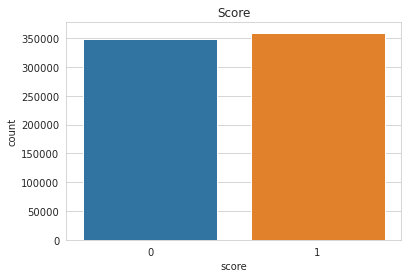

In [206]:
#observamos la distribución de las calificaciones
plt.title("Score")
df = pd.read_csv('data/df_ratings.csv')
sns.countplot(x='score',data=df)
plt.show()

Se observa el rating asignado, 0 es para calificaciones negativas (49.2%) y 1 para las positivas (50.8%)

### **Encode**

Encodeamos el nombre del juego así tener una variable numerica y con números consecutivos. También encodeamos el nombre de usuario ya que los ID proporcionados la mayoria de los datos son nulos, con lo cual al cargar el dataset se descartó esa columna para luego crear un identificador manualmente. Esto lo hacemos para poder ordenar la feature de usuarios de forma ascendente o descendente para luego poder filtrar, así tomar una muestra más pequeña así probar que todo corra corectamente antes de migrar al escenario de big data.

Hacer un rectangulo, tomar esos datos y pasarlos al modelo. Usar label encoder para encodear los nombres de los usuarios y también el product id, así tener una variable numérica continua y poder filtrar con where y obtener el rectángulo.

Nota: este proceso solo lo hacemos para trabajar con small-data, así poder correr todo el código y luego pasarnos a big-data


In [208]:
#Cargamos dataset
df1 = pd.read_csv('data/df_ratings.csv')

In [209]:
df = df1[['product_id','username','app_name','score']]
df.head()

,product_id,username,app_name,score
0,328100,dll3z,Gunspell - Steam Edition,0
1,328100,Nyazicat,Gunspell - Steam Edition,0
2,328100,novocain,Gunspell - Steam Edition,1
3,328100,raixel,Gunspell - Steam Edition,1
4,328100,Shwgar,Gunspell - Steam Edition,0


In [210]:
#Verificamos los tipos de datos 
df.dtypes

product_id     int64
username      object
app_name      object
score          int64
dtype: object

LabelEncoder

In [211]:
# Categorical boolean mask
categorical_feature_mask = df.dtypes==object

In [212]:
# filter categorical columns using mask and turn it into a list
categorical_cols = df.columns[categorical_feature_mask].tolist()
categorical_cols

['username', 'app_name']

In [213]:
# LabelEncoder converts each class under specified feature to a numerical value. Let’s go through the steps to see how to do it.
#Instantiate a LabelEncoder object:
# import labelencoder
from sklearn.preprocessing import LabelEncoder
# instantiate labelencoder object
le = LabelEncoder()

In [214]:
df = df.copy()
#Apply LabelEncoder on each of the categorical columns:
# apply le on categorical feature columns
df[categorical_cols] = df[categorical_cols].apply(lambda col: le.fit_transform(col))

In [215]:
df = df[categorical_cols]
#hacer rename columnas
df.rename(columns={'username': 'user_num', 'app_name': 'app_num'}, inplace=True)

La salida del LabelEncoder aún es un Dataframe. A continuación el resultado:

In [216]:
df.head()

,user_num,app_num
0,390724,3737
1,227307,3737
2,436133,3737
3,444114,3737
4,281618,3737


Concatenamos así agregamos los valores reales

In [217]:
result = pd.concat([df, df1], axis=1, join="inner")

In [218]:
result.head()

,user_num,app_num,product_id,username,app_name,price,hours,score
0,390724,3737,328100,dll3z,Gunspell - Steam Edition,14.99,0.4,0
1,227307,3737,328100,Nyazicat,Gunspell - Steam Edition,14.99,2.2,0
2,436133,3737,328100,novocain,Gunspell - Steam Edition,14.99,3.8,1
3,444114,3737,328100,raixel,Gunspell - Steam Edition,14.99,3.2,1
4,281618,3737,328100,Shwgar,Gunspell - Steam Edition,14.99,1.4,0


In [219]:
result = result[['user_num','app_num','score']]
result.head(5)

,user_num,app_num,score
0,390724,3737,0
1,227307,3737,0
2,436133,3737,1
3,444114,3737,1
4,281618,3737,0


Ordenamos el datast por usuario y juego

In [220]:
result = result.copy()
result.sort_values(['user_num', 'app_num'], ascending=[True, True], inplace=True)
#result.sort_values(['user_num'], ascending=True, inplace=True)

result.head()

,user_num,app_num,score
632914,0,6960,0
320563,1,643,0
416272,1,9202,0
629177,2,1229,1
576688,3,3665,0


In [221]:
result.shape

(707312, 3)

In [222]:
result.user_num.nunique()

494797

In [223]:
result.user_num.isnull().sum()

0

In [224]:
result.app_num.isnull().sum()

0

In [225]:
result.dtypes

user_num    int64
app_num     int64
score       int64
dtype: object

In [226]:
# Cantidad de usuarios cuyo id sea menor a 1000, se observará que el valor es mayoy a 1000 porque hay usuarios que han calificado más de un juego
(result['user_num'] < 1000).sum()

1281

In [227]:
#Aquí verificamos que los usuarios únicos sean igual a 1000
result[result['user_num'] < 1000].nunique()

user_num    1000
app_num      674
score          2
dtype: int64

In [228]:
#(result['app_num'] < 1000).sum()

Creamos filtro para obtener un rectágulo de la matriz, así tener de los usuarios seleccionados todas sus clasificaciones.

In [229]:
## Mascaras/Filtros
filter1 = result['user_num'] < 10000
filter2 = result['app_num'] < 1000

In [230]:
# Filtramos la data a partir de los dos filtros anteriores
dfx =  result.where(filter1 & filter2, inplace = False)

In [231]:
dfx.dropna(inplace=True)
dfx.reset_index(drop=True, inplace=True)

In [232]:
dfx

,user_num,app_num,score
0,1.0,643.0,0.0
1,8.0,639.0,0.0
2,39.0,471.0,0.0
3,51.0,221.0,1.0
4,59.0,454.0,1.0
...,...,...,...
1234,9954.0,358.0,0.0
1235,9969.0,504.0,1.0
1236,9977.0,883.0,1.0
1237,9985.0,392.0,0.0


Guardamos en un csv, el rectángulo.

In [233]:
dfx.to_csv('data/df_rating_encoded_rectangulo_1.csv', index= False)

Graficamos la cantidad de calificaciones por usuario

In [234]:
data = dfx.groupby('user_num')['app_num'].count().clip(upper=5)

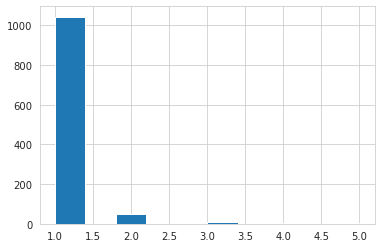

In [235]:
data.hist()
plt.show()

La mayoria tiene 1 calificación, muy pocos 2.

### **Implementación de Sistemas de Recomendación**

Objetivo:

Deacuerdo a la populariad del juego, similiritadad de la descripciónn del juego, la calidad del juego, y según las preferencias de los jugadores se le recomendaría un juego.

- Parte 1: Sistema de recomendación Basado en Popularidad
- Parte 2: Filtro Colaborativo

#### **1) Sistema de recomendación Basado en Popularidad**

Para los nuevo usuarios de la plataforma de Steam, no conocemos nada, la forma más eficiente para esos usuarios de hacerles conocer de la plataforma es de ofrecerles los juegos más populares según los usuarios previos. Además, estos juegos no tienen limitación de tiempo. Son los juegos juegos más populares desde el tiempo de su aparición en la plataforma.

1. Primero necesitamos extraer 'product_id','username','app_name','price', luego extraer la información del top 100 de los juegos.
2. Luego ordenamos los juegos en orden descendente acuerdo al número de propietarios (Es decir, que el juego con más propietarios, es el juego más popular)

Probamos con pocos datos:

In [237]:
#df = pd.read_csv('data/pruebaUsers.csv', nrows=10000)
df = pd.read_csv('data/df_ratings.csv')
df.shape

(707312, 6)

In [238]:
df1 = df[['product_id','username','app_name','price','hours']]

In [239]:
#data_games = pd.read_csv('data/pruebaGames.csv', nrows=1000)

In [240]:
df1.head()

,product_id,username,app_name,price,hours
0,328100,dll3z,Gunspell - Steam Edition,14.99,0.4
1,328100,Nyazicat,Gunspell - Steam Edition,14.99,2.2
2,328100,novocain,Gunspell - Steam Edition,14.99,3.8
3,328100,raixel,Gunspell - Steam Edition,14.99,3.2
4,328100,Shwgar,Gunspell - Steam Edition,14.99,1.4


#### Juegos más populares según la cantidad de usuarios
A continuación se muestra el ranking de los juegos más populares en la plataforma Steam.

In [241]:
# relizamos conteno por nombre del juego y luego ordenamos de manera descendente
df_top = df1.app_name.value_counts().sort_values(ascending = False)

df_top = pd.DataFrame(df_top)
df_top['top_game'] = df_top.index
df_top.rename({'app_name': 'cnt'}, axis=1, inplace=True)
df_top.reset_index(drop=True, inplace=True)
df_top = df_top[['top_game','cnt']].sort_values(['cnt'], ascending=False)
df_top.head(10)

,top_game,cnt
0,Team Fortress 2,17317
1,Rust,9244
2,Borderlands 2,6760
3,Fallout 4,6554
4,Grand Theft Auto V,5545
5,Undertale,5282
6,Warframe,5155
7,Portal 2,5023
8,DayZ,4976
9,Robocraft,4765


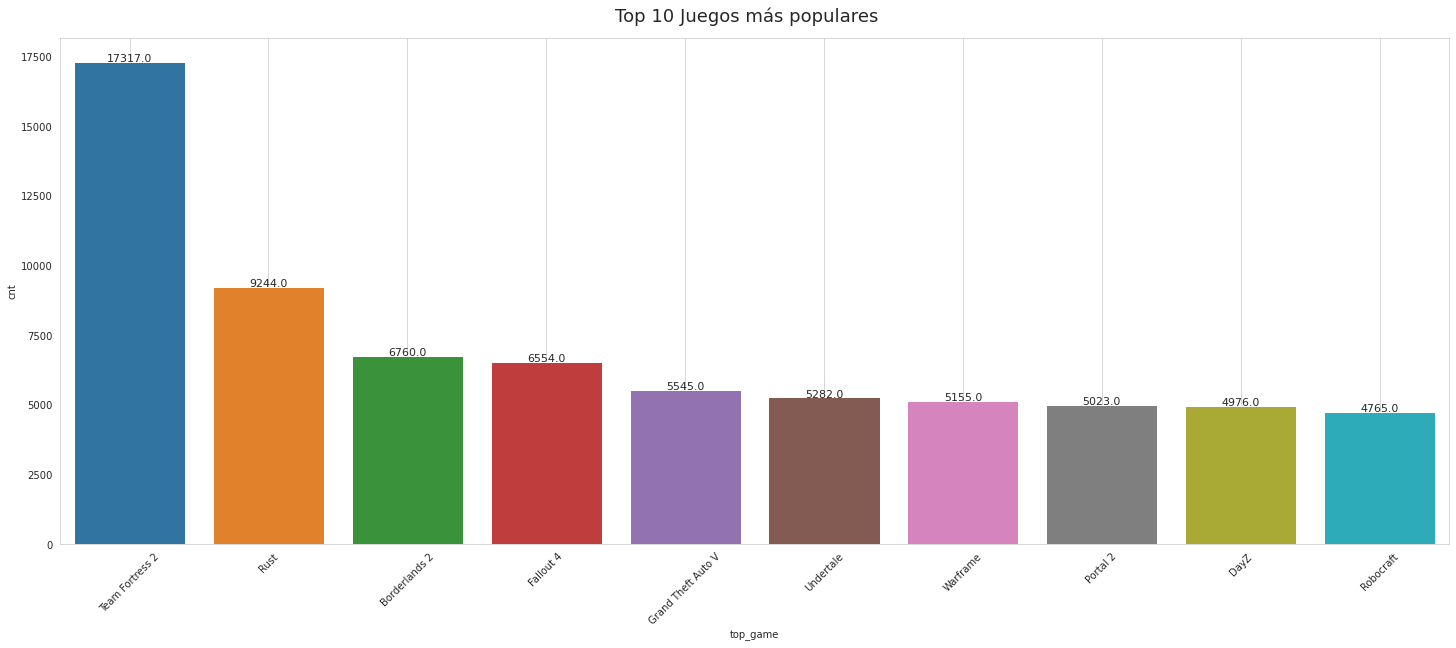

In [242]:
## creamos la figura con subplots de 1 linea 2 columnas
fig, axes = plt.subplots(1,1, figsize=(20, 8))
fig.suptitle('Top 10 Juegos más populares', fontsize=18)
#padding between subplots. Pass a float parameter to specify the amount of padding between subplots.
fig.tight_layout(pad=1.0)

# GRacount 0
#sns.countplot(data = df_top, x = "top_game", orient='v', ax=axes, order = df_top['cnt'].value_counts().index)
sns.barplot(x="top_game", y="cnt", ax=axes,orient="v", data=df_top.head(10))
#axes.set_title("Todas los tipos: ",fontsize = 10, color = "w", fontstretch=0, backgroundcolor="SteelBlue")
#plt.sca(axes[0, 1])
plt.sca(axes)
plt.xticks(rotation=45)
plt.grid()

for rect in axes.patches:
    axes.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)


Es decir, a los clientes que recién ingresen a la plataforma se le recomendará los juegos más populares, tomado del top_10 de manera aleatoria:

In [243]:
import random

#print(random.randrange(10))
def reco_new_user():
    #print(df_top.top_game[random.randrange(10)])
    return df_top.top_game[random.randrange(10)]

In [246]:
print("Recomendación usuario nuevo a la plataforma:")
reco_new_user()

Recomendación usuario nuevo a la plataforma:


'Rust'

#### **2) Filtro Colaborativo**

A los usuarios se le recomiendan artículos que a personas con gustos y preferencias similares les gustaban en el pasado. En otras palabras, este método predice calificaciones desconocidas utilizando las similitudes entre los usuarios.

Usaremos la libreria `Surprise`  y  probaremos varios algoritmos para ver cual es que obtiene un menor RMSE (Root Mean Absolute Error) y si vale la pena por tiempo de computo ya que estamos trabajando con Big Data. Recordar que el rating es una variable binario (0,1)


Con la biblioteca `Surprise`, compararemos los siguientes algoritmos: <br>

**Algoritmos básicos** <br>

`NormalPredictor` El algoritmo NormalPredictor predice una clasificación aleatoria basada en la distribución del conjunto de entrenamiento, que se supone que es normal. Este es uno de los algoritmos más básicos que no hace mucho trabajo. <br>
`BaselineOnly`
El algoritmo BaselineOnly predice la estimación de baseline para un usuario y elemento determinados.


**algoritmos k-NN**

`KNNBasic` : KNNBasic es un algoritmo de filtrado colaborativo básico. <br>
`KNNWithMeans`: KNNWithMeans es un algoritmo de filtrado colaborativo básico, teniendo en cuenta las valoraciones medias de cada usuario. <br>
`KNNWithZScore`: KNNWithZScore es un algoritmo de filtrado colaborativo básico que tiene en cuenta la normalización del z-score de cada usuario. <br>
`KNNBaseline`: KNNBaseline es un algoritmo de filtrado colaborativo básico que tiene en cuenta una calificación de referencia. <br>

**Algoritmos basados en la factorización de matrices**

`SVD` : El algoritmo SVD es equivalente a la factorización matricial probabilística <br>
`SVDpp`: El algoritmo SVDpp es una extensión de SVD que tiene en cuenta las calificaciones implícitas. <br>
`NMF`: NMF es un algoritmo de filtrado colaborativo basado en factorización matricial no negativa. Es muy similar con SVD. <br>
`Slope One`: SlopeOne es una implementación sencilla del algoritmo SlopeOne. <br>
`Co-clustering`:  Coclustering es un algoritmo de filtrado colaborativo basado en co-clustering. <br>

Usamos "RMSE" como nuestra métrica de precisión para las predicciones, que es la métrica utilizada por la mayoría en los filtros coloborativos.

#### **Manos a la obra con Surprice**

Primero se probó con una pequeña matriz o rectangulo, en donde tenemos todos los datos de un usuario en particular, es decir del usuario 1 tenemos todas la calificaciones. Para obtener esa matriz, se tuvo que encodear los nombres de usuarios para poder ordenarlos y tener todas las calificaciones de los usuarios seleccionados.  Esto lo usuamos para reducir tiempo de procesamiento y validar nuestro modelo.

Luego una vez validado el modelo con los datos anteriores pasamos a utilizar el dataset total, a este le hacemos el train test split y luego aplicamos la predicciones.

In [ ]:
## Importamos lo necesario 
### Surprice
## conda install -c conda-forge scikit-surprise

import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse, mae
from surprise import accuracy
from surprise.model_selection import train_test_split

Surprise necesita un conjunto de datos, con tres variables: identificación de usuario, identificación del artículo y calificación. Esto es importante, no hay que pasar las calificaciones en un formato de matriz de calificaciones de elementos de usuario. El dataset tiene 3 columnas y el número de filas es igual al número total de calificaciones individuales. A continuación cargamos el dataset (user_num, app_num, score):

In [ ]:
## Cargamos el dataset con un rectágulo de los datos
#ratings = pd.read_csv('data/trainUsers.csv')
ratings = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/SPRINT_3/df_rating_encoded_rectangulo_1.csv')
ratings.head()

,user_num,app_num,score
0,1.0,802.0,1.0
1,9.0,798.0,1.0
2,45.0,590.0,1.0
3,53.0,669.0,1.0
4,57.0,283.0,1.0


Se crea el objeto Reader, con los siguientes atributos:
- line_format: asegurar que el orden corresponda con el del dataset
- sep: es coma, si estamos trabajando con csv
- rating_scale: is una tuple con el menor y mayor rango posible. Es importante establecer correctamente este parámetro, porque en caso contrario cierta data puede ser ignorada. Si usamos un score binario, el valor correcto es la tupla (0,1)

In [ ]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0, 1))

De esta forma, se define el objeto `Reader` para que Surprise pueda parsear el archivo o el dataframe. Para cargar un conjunto de datos desde un archivo (por ejemplo, un archivo csv), necesita el método `load_from_file()`. Para cargar un conjunto de datos desde un Dataframe de pandas, necesitará el método `load_from_df()`. También es necesario el objeto Reader, pero solo se debe especificar el parámetro rating_scale. El Dataframe debe tener tres columnas, correspondientes a los ID de usuario (sin procesar), los ID de elemento (sin procesar) y las calificaciones en este orden. Por lo tanto, cada fila corresponde a una calificación determinada. Esto no es restrictivo, ya que puede reordenar las columnas del Dataframe fácilmente.

Para importar la data, usamos el método `load_form_file`, luego de esto ya tenemos el dataset en formato `surprise` 

In [ ]:
ratings = ratings[['user_num','app_num','score']]
#ratings = ratings[['username','app_name','score']]
data = Dataset.load_from_df(ratings, reader)
#data.split(n_folds=5)

De la clase `model_selection` importamos el método `train_test_split`. Dividimos la data en `trainset` y `testset`, `test_size` está seteado al 20%. Una vez más, es un poco diferente de cómo funcionaría un modelo de clasificador / regresión, el conjunto de pruebas contiene calificaciones de usuarios/elementos seleccionados al azar, en lugar de usuarios / elementos completos. Un usuario puede tener 10 calificaciones en los datos, y 3 de ellas ahora se seleccionan al azar para el conjunto de pruebas, no para ser utilizadas para ajustar el modelo. Tiene mucho sentido no omitir por completo a ciertos usuarios.

In [ ]:
trainset, testset = train_test_split(data, test_size=0.2)

El segundo enfoque es utilizar los datos completos y realizar una validación cruzada para las pruebas. En ese caso, podemos construir un objeto Trainset usando todas las calificaciones con el método build_full_trainset:

In [ ]:
trainsetfull = data.build_full_trainset()

Para obtener la cantidad de elementos / usuarios usamos los métodos n_users y n_items (el mismo enfoque funciona para trainsetfull, porque son el mismo tipo de objeto):

In [ ]:
print('Numero de usuarios: ', trainset.n_users, '\n')
print('Numero de items:   ', trainset.n_items, '\n')

Numero de usuarios:  698 

Numero de items:    168 



Cuando `surprise` crea un objeto `Trainset` o `Testset`, toma los `raw_id` (los que usó en el archivo que importó) y los convierte en los llamados `inner_id` (básicamente una serie de números enteros, comenzando desde 0). Es posible que deba rastrear hasta los nombres originales. Usando los elementos como ejemplo (puede hacer el mismo enfoque con los usuarios, simplemente intercambie `iid` con `uid` en el código), para obtener la lista de `inner_iids`, se puede usar el método `all_items`. Para convertir de raw a ID interno, puede usar el método `to_inner_iid` y el `to_raw_iid` para volver a convertir.
Un ejemplo sobre cómo guardar una lista de ID de elementos internos y sin procesar:

In [ ]:
### Para convertir los items ids de surprise a los originales del DataFrame
trainset_iids = list(trainset.all_items())
iid_converter = lambda x: trainset.to_raw_iid(x)
trainset_raw_iids = list(map(iid_converter, trainset_iids))

In [ ]:
trainset_raw_iids[:5]

[23.0, 380.0, 802.0, 568.0, 283.0]

In [ ]:
# ### Para convertir los users ids de surprise a los originales del Dataframe
trainset_uids = list(trainset.all_items())
uid_converter = lambda x: trainset.to_raw_uid(x)
trainset_raw_uids = list(map(uid_converter, trainset_uids))

In [ ]:
#obtenemos los uids originales
trainset_raw_uids[:5]

[6282.0, 4462.0, 6983.0, 65.0, 3853.0]

#### Creamos un Benchmark

Para crear un benchmark probamos varios algoritmos, obtenemos su RMSE y el tiempo de procesamiento. Este último será también considerado ya que se correrá finalmente el dataset completo, es decir estaremos trabajando con big-data y el tiempo/cpu son características valiosas que hay que tener en cuenta.

In [ ]:
benchmark = []
# Iterar sobre todos los algoritmos
for algo in [SVD(), SVDpp(), SlopeOne(), NMF(n_factors=0), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    #print(algo)
    results = cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Obtener los resultados y agregarle el nombre del algoritmo (append) 
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algo).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
resultado = pd.DataFrame(benchmark).set_index('Algorithm').sort_values(['test_rmse','fit_time'])  

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


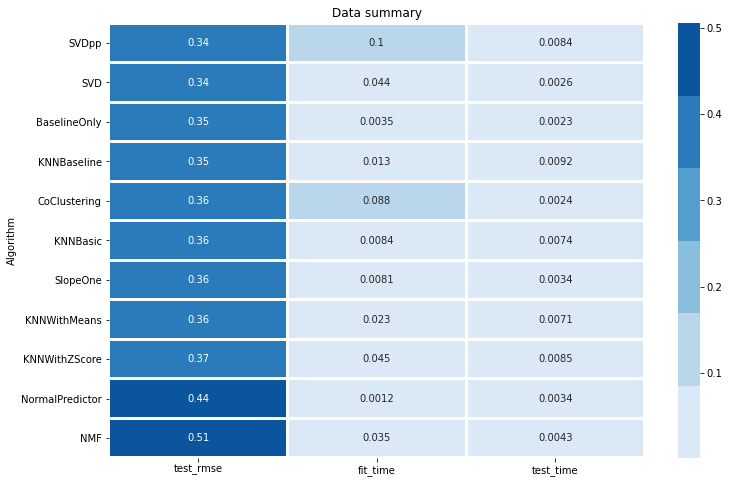

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns


plt.figure(figsize=(12,8))
sns.heatmap(resultado,
            annot=True,linecolor="w",
            linewidth=2,cmap=sns.color_palette("Blues"))
plt.title("Data summary")
plt.show()

Algoritmos elejidos, KNNBaseline, BaselineOnly y SVDpp, son los que menor tiempo de de entrenamiento tienen y RMSE.

### Train y Predict con Big Data
Con el algoritmo SVD obtuvimos el mejor RMSE, ahora vamos a entrenar y predecir con SVD y usar Alternating Least Squares (ALS).

In [ ]:
## Cargamos el dataset con un rectágulo de los datos
ratings = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/SPRINT_3/df_scores2.csv')
ratings.head()

,product_id,username,app_name,price,hours,score
0,725280,Chaos Syren,Psi Project,2.99,0.1,1
1,725280,freakfantom,Psi Project,2.99,0.1,0
2,328100,Ariman1,Gunspell - Steam Edition,14.99,13.2,1
3,328100,dll3z,Gunspell - Steam Edition,14.99,0.4,0
4,328100,Nyazicat,Gunspell - Steam Edition,14.99,2.2,1


In [ ]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0, 1))

Para importar la data, usamos el método `load_form_file`, luego de esto ya tenemos el dataset en formato `surprise` 

In [ ]:
ratings = ratings[['username','app_name','score']]
data = Dataset.load_from_df(ratings, reader)
#data.split(n_folds=5)

Usamos el método `train_test_split()` para crear el trainset y testset, y emplearemos la metrica accuracy de RMSE. Luego usamos el método fil() con el cual vamos a entrenar el algoritmo sobre el `trainset`, y el método test() el cual retorna las predicciones hechas sobre el`testset`.

In [ ]:
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }

In [ ]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = BaselineOnly(bsl_options=bsl_options)
#algo = BaselineOnly()
predictions = algo.fit(trainset).test(testset)

Estimating biases using als...


In [ ]:
# Metrica RMSE
accuracy.rmse(predictions)

RMSE: 0.3100


0.3100315897062972

Al finalizar usaremos los datos completos y realizar una validación cruzada para las pruebas. En ese caso, podemos construir un objeto Trainset usando todas las calificaciones con el método build_full_trainset:

In [ ]:
trainsetfull = data.build_full_trainset()

Los usuarios y los elementos tienen una identificación sin formato (`raw id`) y una identificación interna(`inner id`). Algunos métodos usarán/devolverán una identificación sin formato (`raw id`) (por ejemplo, el método predict ()), mientras que otros usarán/devolverán una identificación interna (`inner id`).

Los identificadores sin procesar (`raw id`) son identificadores definidos en un archivo de clasificación o en un dataframe de pandas. Pueden ser cadenas o números. Sin embargo, hay que tener en cuenta que si las calificaciones se leyeron de un archivo, que es el escenario estándar, se representan como cadenas. Es importante saber si está utilizando, por ejemplo, predict() u otros métodos que aceptan ID sin formato (`raw id`) como parámetros.

En la creación del conjunto tainset, cada ID sin formato (`raw id`) se asigna a un número entero único llamado ID interno (`inner id`), que es mucho más adecuado para que Surprise lo manipule. Las conversiones entre ID sin procesar (`raw id`) e internos (`inner id`) se pueden realizar utilizando los métodos: to_inner_uid (), to_inner_iid (), to_raw_uid () y to_raw_iid () del conjunto de trainset.

Para hacer una predicción, usamos las ID sin procesar (`raw id`), por lo que para obtener la calificación estimada del usuario "Chaos Syren" con la identificación de juego "Psi Project", necesita el método de predict() de su algoritmo entrenado:

In [ ]:
algo.predict(uid = 'Chaos Syren', iid = 'Psi Project')

Prediction(uid='Chaos Syren', iid='Psi Project', r_ui=None, est=0.7780107068392027, details={'was_impossible': False})

r_ui es None, porque el usuario no tiene actualmente un rating para ese item. `est`, es la calificación estimada en la que estamos interesados, en este caso el rating estimado es de 0.88

#### Top-10 recommendations para cada usuario

A continuación el top-10 items con el valor más alto de rating de predicción para cada usuario del dataset. Entrenamos un modelo con el argoritmo elegido con todo el dataset, y predecimos todos los ratings para todos los pares (usuarios, items) que no están en el set de entrenamiento. Obtenemos el top-1' de las predicciones para cada usuarios.

Sistema recomendador, sacar the top best y el top_worst, con esto puedo sacar una porción del best(80%) que sabemso que le va a gustar y tratar de sorprender al usuario introducien do valores nuevos con el de Worst, así si el usuario llega a dar un me gusta alguno de los items recomendados podemos usar eso para retroalimenar nuestro modelo

In [ ]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
#best_predictions = df.sort_values(by='err')[:10]
#worst_predictions = df.sort_values(by='err')[-10:]
best_predictions = df.sort_values(by='err',ascending=True)
worst_predictions = df.sort_values(by='err',ascending=False)

In [ ]:
best_predictions.shape

(194988, 8)

#### Mejores predicciones

In [ ]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
23383,Alien,Grand Theft Auto V,1.0,1.0,{'was_impossible': False},14,4476,0.0
21540,XxScoobySnackzxX,Half-Life 2: Lost Coast,0.0,0.0,{'was_impossible': False},26,209,0.0
31620,Baba Yaga,Borderlands: The Pre-Sequel,1.0,1.0,{'was_impossible': False},9,451,0.0
54884,Berto,Mass Effect,1.0,1.0,{'was_impossible': False},10,244,0.0
108138,Leighton,Banished,1.0,1.0,{'was_impossible': False},4,1121,0.0
...,...,...,...,...,...,...,...,...
49333,GasMask,4x4 Dream Race,0.0,1.0,{'was_impossible': False},39,0,1.0
138758,Renee,Endless Legend™,0.0,1.0,{'was_impossible': False},3,535,1.0
65381,BadassFreeman,Metro: Last Light Redux,0.0,1.0,{'was_impossible': False},5,455,1.0
56418,Angelo,Mount & Blade: Warband,0.0,1.0,{'was_impossible': False},7,2754,1.0


In [ ]:
best_predictions.est.value_counts()

1.000000    3284
0.969240    3192
0.971626    1716
0.983824    1215
0.978516    1136
            ... 
0.879872       1
0.957656       1
0.918906       1
0.757394       1
0.678397       1
Name: est, Length: 76840, dtype: int64

#### Peores Predicciones

In [ ]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
178805,lol,Shantae: Half-Genie Hero,0.0,1.0,{'was_impossible': False},37,74,1.0
194329,CB,Nuclear Throne,0.0,1.0,{'was_impossible': False},7,519,1.0
161885,Foxysen,About Elise,0.0,1.0,{'was_impossible': False},21,3,1.0
137850,FlyMeToTheMoon,Fallout 4,0.0,1.0,{'was_impossible': False},2,5350,1.0
95324,Ed,Company of Heroes 2,0.0,1.0,{'was_impossible': False},14,1160,1.0
...,...,...,...,...,...,...,...,...
190762,Erik,Mad Max,1.0,1.0,{'was_impossible': False},8,1190,0.0
190761,Lateralus,Banished,1.0,1.0,{'was_impossible': False},4,1135,0.0
23359,Wolfgang Hype,Starbound,1.0,1.0,{'was_impossible': False},4,3287,0.0
59272,Saint Aaron,Black Sails - The Ghost Ship,1.0,1.0,{'was_impossible': False},81,3,0.0


Por ejemplo, las mejores predicciones, lo que le vamos a recomendar al usuario "lemon" serán

In [ ]:
mask = best_predictions.loc[:, 'uid'] == 'lemon'
user = best_predictions.loc[mask]
user.head()

,uid,iid,rui,est,details,Iu,Ui,err
39773,lemon,Anachronox,1.0,0.783011,{'was_impossible': False},5,14,0.216989
74314,lemon,Rust,0.0,0.991408,{'was_impossible': False},5,7776,0.991408


In [ ]:
best_predictions[best_predictions['uid'] == 'lemon']

,uid,iid,rui,est,details,Iu,Ui,err
39773,lemon,Anachronox,1.0,0.783011,{'was_impossible': False},5,14,0.216989
74314,lemon,Rust,0.0,0.991408,{'was_impossible': False},5,7776,0.991408


In [ ]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


def get_bottom_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    bottom_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        bottom_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in bottom_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=False)
        bottom_n[uid] = user_ratings[:n]

    return bottom_n

#### Predecir los ratings para todos los pares (u,i) que NO están en el conjunto de entrenamiento.

In [ ]:
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

KeyboardInterrupt: ignored

In [ ]:
#### Los mejores ranqueados

In [ ]:
top_n = get_top_n(predictions, n=5)
#bottom_n = get_bottom_n(predictions, n=5)

In [ ]:
top_n

defaultdict(list,
            {'geno': [('Brawlhalla', 0.9029728048230523)],
             'ChrisBalderst0n': [('Clicker Heroes', 0.75639683184131),
              ('BEEP', 0.3872622443704108),
              ('Super Crate Box', 0.3614642653802991),
              ("Bad Rats: the Rats' Revenge", 0.30992360134059616),
              ('Famaze', 0.2087962643107582)],
             'jIMB0': [('ARK: Survival Evolved', 0.9305690057915093)],
             'Tetsuo ShadowKnight': [('Ghostship Aftermath',
               0.6628442319451154)],
             'kjmkennedy': [('Fallout 4', 0.9888316987076806)],
             'Amika Chan': [('Blood and Bacon', 0.7828640226287065)],
             'ShadyOtaku': [('Mount & Blade: Warband', 0.9868515222488884),
              ('Sanctum 2', 0.8589906960615384)],
             'Elvis': [('Rocksmith® 2014 Edition - Remastered',
               0.8697116638741287),
              ('Spiral Knights', 0.7756362990429821),
              ('Elsword', 0.7564056512423161)],
       

In [ ]:
#algo.predict(uid = 'lemon', iid = 'Rust')

In [ ]:
#data = pd.DataFrame([top_n])

In [ ]:
bottom_n = get_bottom_n(predictions, n=5)

In [ ]:
bottom_n

In [ ]:
from collections import defaultdict

#from surprise import SVD
#from surprise import Dataset


def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n 



In [ ]:

def get_bottom_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=False)
        bottom_n[uid] = user_ratings[:n]

    return bottom_n


In [ ]:
##### top
print("XXXXXXXXXXXXXXXXXXXX top #############################")

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

Se truncaron las últimas líneas 5000 del resultado de transmisión.
[MFH] Git Good abilities ['Sniper Elite V2']
PoppyCow ['The Binding of Isaac: Rebirth']
Chocolate Loli·pop ["The Beginner's Guide"]
Tobiichi Origami ['Total War Battles: KINGDOM']
swat37 ['Postal III']
✪Rhuzky ['Paladins®']
|Hugh| Dasbora ['FINAL FANTASY XIV Online']
gibbo ['Euro Truck Simulator 2']
Demos ['Nether: Resurrected']
Helliex ['Arma 3']
Lyra9852 🐦 🐉 ['The Binding of Isaac']
LY ['Borderlands: The Pre-Sequel']
Xeinix ['Brawlhalla']
Nigel Barrage ['Arma 2: Operation Arrowhead']
Delicate Unicorn ['Hotline Miami']
williamweb2002 ['STAR WARS™ Empire at War - Gold Pack']
3Vingers ['AdVenture Capitalist']
mrmarshall_66 ['Star Crusade CCG']
TheWateringWizard ['STAR WARS™ Jedi Knight - Jedi Academy™']
Obviously Dracula ['Yonder: The Cloud Catcher Chronicles']
Sanguine-Tarsier ['Trine 3: The Artifacts of Power']
Mr Spits ['XCOM® 2', 'Arma 3']
Chepre ['EVE Online']
Adam Savage ['DARK SOULS™ III']
Rehad ['NARUTO SHIPPUDEN

In [ ]:
#### bottom
print("XXXXXXXXXXXXXXXXXXXX bottom #############################")
bottom_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in bottom_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

In [ ]:
# Use the famous SVD algorithm.
algo = SVD()

# Run 5-fold cross-validation and print results.
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

NameError: ignored

In [ ]:
from surprise import BaselineOnly
cross_validate(BaselineOnly(), data, verbose=True)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.3368  0.3019  0.3763  0.3291  0.3747  0.3438  0.0284  
MAE (testset)     0.2167  0.2087  0.2426  0.2263  0.2297  0.2248  0.0116  
Fit time          0.00    0.01    0.01    0.00    0.00    0.01    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    


{'test_rmse': array([0.33682464, 0.30185643, 0.37630609, 0.32911838, 0.37472748]),
 'test_mae': array([0.21674022, 0.20871582, 0.24260243, 0.22626891, 0.22974783]),
 'fit_time': (0.002812623977661133,
  0.0075533390045166016,
  0.00998377799987793,
  0.002819061279296875,
  0.004692554473876953),
 'test_time': (0.0017664432525634766,
  0.0017070770263671875,
  0.001867532730102539,
  0.0017619132995605469,
  0.0010361671447753906)}

### Benchmarks
Here are the average RMSE, MAE and total execution time of various algorithms (with their default parameters) on a 5-fold cross-validation procedure. The folds are the same for all the algorithms. All experiments are run on a notebook with Intel Core i5 7th gen (2.5 GHz) and 8Go RAM. The code for generating these tables can be found in the benchmark example.

In [ ]:
# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25)

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.3376


0.3376417136263484

In [ ]:
#Note that you can train and test an algorithm with the following one-line:
predictions = algo.fit(trainset).test(testset)

In [ ]:
from surprise import KNNBasic
# Build an algorithm, and train it.
algo = KNNBasic()
algo.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


We can now predict ratings by directly calling the predict() method. Let’s say you’re interested in user 196 and item 302 (make sure they’re in the trainset!), and you know that the true rating 

In [ ]:
uid = str(45.0)  # raw user id (as in the ratings file). They are **strings**!
iid = str(590.0)  # raw item id (as in the ratings file). They are **strings**!

# get a prediction for specific users and items.
pred = algo.predict(uid, iid, r_ui=4, verbose=True)

user: 45.0       item: 590.0      r_ui = 4.00   est = 0.84   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


In [ ]:
The predict() uses raw ids (please read this about raw and inner ids). As the dataset we have used has been read from a file, the raw ids are strings (even if they represent numbers).

In [ ]:
uid = str(57.0)  # raw user id (as in the ratings file). They are **strings**!
iid = str(283.0)  # raw item id (as in the ratings file). They are **strings**!

# get a prediction for specific users and items.
pred = algo.predict(uid, iid, r_ui=4, verbose=True)

user: 57.0       item: 283.0      r_ui = 4.00   est = 0.84   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


In [ ]:
2) Probamos con el dataset completo

In [ ]:
ratings = pd.read_csv('data/df_scores2.csv')
ratings.head()

,product_id,username,app_name,price,hours,score
0,725280,Chaos Syren,Psi Project,2.99,0.1,1
1,725280,freakfantom,Psi Project,2.99,0.1,0
2,328100,Ariman1,Gunspell - Steam Edition,14.99,13.2,1
3,328100,dll3z,Gunspell - Steam Edition,14.99,0.4,0
4,328100,Nyazicat,Gunspell - Steam Edition,14.99,2.2,1


In [ ]:
dfx

,user_num,app_num,score
0,1.0,802.0,1.0
1,9.0,798.0,1.0
2,45.0,590.0,1.0
3,53.0,669.0,1.0
4,57.0,283.0,1.0
...,...,...,...
1012,9930.0,779.0,0.0
1013,9932.0,779.0,0.0
1014,9944.0,238.0,0.0
1015,9950.0,870.0,1.0


In [ ]:
#ratings = ratings[['product_id','app_name','score']]
ratings = dfx[['user_num','app_num','score']]

In [ ]:

data = Dataset.load_from_df(ratings, reader)
#data.split(n_folds=5)

# Use the famous SVD algorithm
algo = SVD()

# Run 5-fold cross-validation and then print results
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

NameError: name 'Dataset' is not defined

We get a mean Root Mean Sqaure Error of 0.8963 which is more than good enough for our case. Let us now train on our dataset and arrive at predictions.

In [ ]:
ratings[ratings['username'] == 'Ariman1']

,username,app_name,score
2,Ariman1,Gunspell - Steam Edition,1
355378,Ariman1,Stone Age Wars,0
545052,Ariman1,Green Ranch,1


username    object
app_name    object
score        int64
dtype: object

In [ ]:
df1 = df[['product_id','username','app_name','price']]

In [ ]:
Pop_rec = df1.groupby(['product_id'], as_index=False)['price'].count().sort_values(['price'], ascending=False)

In [ ]:
Pop_rec = df1['product_id'].value_counts().head(100)
Pop_rec.head()
Pop_rec = pd.DataFrame(Pop_rec)
Pop_rec['product_top'] = Pop_rec.index
Pop_rec.rename({'product_id': 'cnt'}, axis=1, inplace=True)
Pop_rec.reset_index(drop=True, inplace=True)
Pop_rec = Pop_rec[['product_top','cnt']].sort_values(['cnt'], ascending=False)
Pop_rec.head(5)

,product_top,cnt
0,440,18373
1,252490,10221
2,49520,7321
3,377160,7113
4,271590,5976


In [ ]:
#data_games[data_games.id == '440']

<AxesSubplot:xlabel='product_top', ylabel='cnt'>

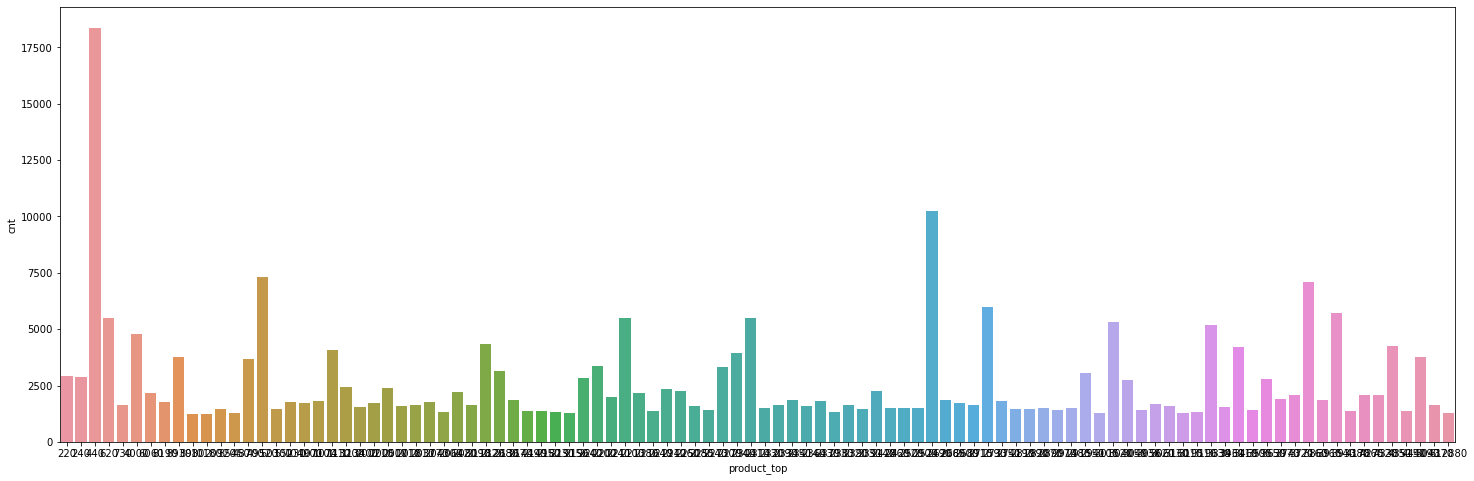

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(25, 8))
sns.barplot(x="product_top", y="cnt", data=Pop_rec)

In [ ]:
#data_reviews_2 = data_reviews[['username','product_id']]
#data_reviews_2

In [ ]:
#data_games.shape

In [ ]:
#mergeado.head()

In [ ]:
df[['username','product_id','title']]

KeyError: "['title'] not in index"